# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

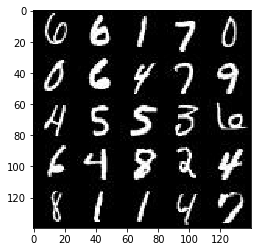

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

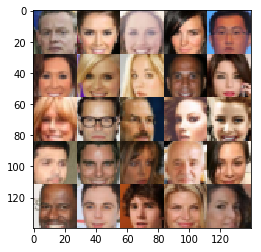

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [95]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images * 2., 64, 5, strides=2, padding='same', \
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same', \
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same', \
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        
        logits = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(logits, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [89]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        fc = tf.layers.dense(z, 7 * 7 * 512)
        
        fc = tf.reshape(fc, (-1, 7, 7, 512))
        fc = tf.layers.batch_normalization(fc, training=is_train)
        fc = tf.maximum(alpha * fc, fc)
        
        conv1 = tf.layers.conv2d_transpose(fc, 256, 5, strides=2, padding='same', \
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding='same', \
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=1, padding='same', \
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [90]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [91]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [92]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [111]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    iterations = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # make sure the inputs range from -1 to 1
                batch_images = batch_images * 2
                
                iterations += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if iterations % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print('Epoch {} out of {}'.format(epoch_i + 1, epochs))
                    print('Iteration {}'.format(iterations))
                    print('Discriminator loss: {:.6f}'.format(train_loss_d))
                    print('Generator loss: {:.6f}'.format(train_loss_g))
                    print('=' * 15)
                
                if iterations % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1 out of 2
Iteration 10
Discriminator loss: 0.465071
Generator loss: 2.542798
Epoch 1 out of 2
Iteration 20
Discriminator loss: 0.704013
Generator loss: 1.374265
Epoch 1 out of 2
Iteration 30
Discriminator loss: 1.579813
Generator loss: 4.614997
Epoch 1 out of 2
Iteration 40
Discriminator loss: 0.779875
Generator loss: 1.811049
Epoch 1 out of 2
Iteration 50
Discriminator loss: 1.514522
Generator loss: 0.752426
Epoch 1 out of 2
Iteration 60
Discriminator loss: 0.849975
Generator loss: 1.489880
Epoch 1 out of 2
Iteration 70
Discriminator loss: 0.897599
Generator loss: 1.452857
Epoch 1 out of 2
Iteration 80
Discriminator loss: 0.931503
Generator loss: 1.523070
Epoch 1 out of 2
Iteration 90
Discriminator loss: 0.950457
Generator loss: 1.294697
Epoch 1 out of 2
Iteration 100
Discriminator loss: 1.389392
Generator loss: 0.945542


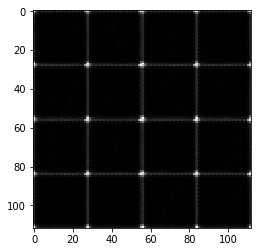

Epoch 1 out of 2
Iteration 110
Discriminator loss: 1.497258
Generator loss: 0.569606
Epoch 1 out of 2
Iteration 120
Discriminator loss: 1.487552
Generator loss: 0.621812
Epoch 1 out of 2
Iteration 130
Discriminator loss: 1.705839
Generator loss: 0.412245
Epoch 1 out of 2
Iteration 140
Discriminator loss: 1.255168
Generator loss: 1.058099
Epoch 1 out of 2
Iteration 150
Discriminator loss: 1.470637
Generator loss: 0.582340
Epoch 1 out of 2
Iteration 160
Discriminator loss: 1.648017
Generator loss: 0.393959
Epoch 1 out of 2
Iteration 170
Discriminator loss: 1.188754
Generator loss: 0.812806
Epoch 1 out of 2
Iteration 180
Discriminator loss: 1.275961
Generator loss: 1.486717
Epoch 1 out of 2
Iteration 190
Discriminator loss: 1.333701
Generator loss: 0.663761
Epoch 1 out of 2
Iteration 200
Discriminator loss: 1.336006
Generator loss: 0.700888


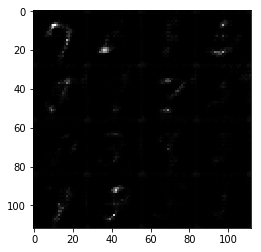

Epoch 1 out of 2
Iteration 210
Discriminator loss: 1.090556
Generator loss: 1.204594
Epoch 1 out of 2
Iteration 220
Discriminator loss: 1.245241
Generator loss: 0.887319
Epoch 1 out of 2
Iteration 230
Discriminator loss: 1.260391
Generator loss: 0.629995
Epoch 1 out of 2
Iteration 240
Discriminator loss: 1.393232
Generator loss: 0.551101
Epoch 1 out of 2
Iteration 250
Discriminator loss: 1.137237
Generator loss: 0.791477
Epoch 1 out of 2
Iteration 260
Discriminator loss: 1.607456
Generator loss: 0.398675
Epoch 1 out of 2
Iteration 270
Discriminator loss: 1.163598
Generator loss: 1.756295
Epoch 1 out of 2
Iteration 280
Discriminator loss: 1.070777
Generator loss: 0.984961
Epoch 1 out of 2
Iteration 290
Discriminator loss: 1.127469
Generator loss: 0.950086
Epoch 1 out of 2
Iteration 300
Discriminator loss: 1.435872
Generator loss: 0.567557


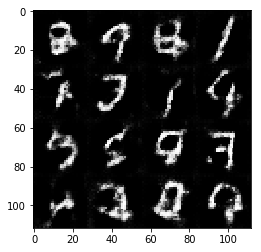

Epoch 1 out of 2
Iteration 310
Discriminator loss: 1.314590
Generator loss: 0.609157
Epoch 1 out of 2
Iteration 320
Discriminator loss: 1.437346
Generator loss: 0.552470
Epoch 1 out of 2
Iteration 330
Discriminator loss: 1.223301
Generator loss: 0.646913
Epoch 1 out of 2
Iteration 340
Discriminator loss: 1.513983
Generator loss: 0.439104
Epoch 1 out of 2
Iteration 350
Discriminator loss: 1.118584
Generator loss: 0.830513
Epoch 1 out of 2
Iteration 360
Discriminator loss: 1.337615
Generator loss: 1.595385
Epoch 1 out of 2
Iteration 370
Discriminator loss: 1.092085
Generator loss: 0.923168
Epoch 1 out of 2
Iteration 380
Discriminator loss: 1.571278
Generator loss: 0.428429
Epoch 1 out of 2
Iteration 390
Discriminator loss: 1.084697
Generator loss: 0.932614
Epoch 1 out of 2
Iteration 400
Discriminator loss: 1.390145
Generator loss: 0.670565


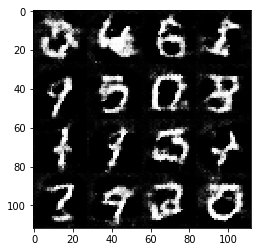

Epoch 1 out of 2
Iteration 410
Discriminator loss: 1.180789
Generator loss: 1.343949
Epoch 1 out of 2
Iteration 420
Discriminator loss: 1.341706
Generator loss: 0.544913
Epoch 1 out of 2
Iteration 430
Discriminator loss: 1.290221
Generator loss: 0.669417
Epoch 1 out of 2
Iteration 440
Discriminator loss: 1.398247
Generator loss: 0.616245
Epoch 1 out of 2
Iteration 450
Discriminator loss: 1.609025
Generator loss: 0.383174
Epoch 1 out of 2
Iteration 460
Discriminator loss: 1.303294
Generator loss: 1.733896
Epoch 1 out of 2
Iteration 470
Discriminator loss: 1.543713
Generator loss: 0.449266
Epoch 1 out of 2
Iteration 480
Discriminator loss: 1.123936
Generator loss: 1.066205
Epoch 1 out of 2
Iteration 490
Discriminator loss: 1.321121
Generator loss: 0.571870
Epoch 1 out of 2
Iteration 500
Discriminator loss: 1.334091
Generator loss: 1.933881


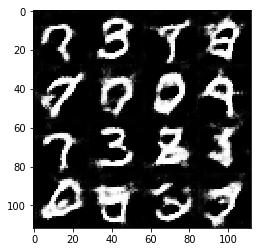

Epoch 1 out of 2
Iteration 510
Discriminator loss: 1.197298
Generator loss: 0.700449
Epoch 1 out of 2
Iteration 520
Discriminator loss: 1.210359
Generator loss: 0.881790
Epoch 1 out of 2
Iteration 530
Discriminator loss: 1.252791
Generator loss: 0.768964
Epoch 1 out of 2
Iteration 540
Discriminator loss: 1.109878
Generator loss: 0.942142
Epoch 1 out of 2
Iteration 550
Discriminator loss: 1.294966
Generator loss: 0.590219
Epoch 1 out of 2
Iteration 560
Discriminator loss: 0.969917
Generator loss: 1.027413
Epoch 1 out of 2
Iteration 570
Discriminator loss: 1.057864
Generator loss: 1.042237
Epoch 1 out of 2
Iteration 580
Discriminator loss: 1.159806
Generator loss: 0.890396
Epoch 1 out of 2
Iteration 590
Discriminator loss: 1.162635
Generator loss: 1.500123
Epoch 1 out of 2
Iteration 600
Discriminator loss: 1.041266
Generator loss: 0.962613


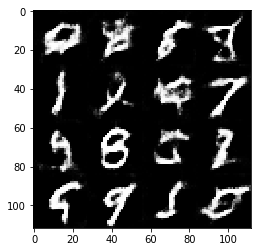

Epoch 1 out of 2
Iteration 610
Discriminator loss: 1.065228
Generator loss: 0.955633
Epoch 1 out of 2
Iteration 620
Discriminator loss: 1.436851
Generator loss: 0.541390
Epoch 1 out of 2
Iteration 630
Discriminator loss: 1.075888
Generator loss: 0.840837
Epoch 1 out of 2
Iteration 640
Discriminator loss: 1.704481
Generator loss: 0.329941
Epoch 1 out of 2
Iteration 650
Discriminator loss: 1.165303
Generator loss: 0.797697
Epoch 1 out of 2
Iteration 660
Discriminator loss: 1.276818
Generator loss: 0.730118
Epoch 1 out of 2
Iteration 670
Discriminator loss: 1.333717
Generator loss: 0.539140
Epoch 1 out of 2
Iteration 680
Discriminator loss: 1.132987
Generator loss: 1.634639
Epoch 1 out of 2
Iteration 690
Discriminator loss: 1.377163
Generator loss: 0.559341
Epoch 1 out of 2
Iteration 700
Discriminator loss: 1.140125
Generator loss: 0.794183


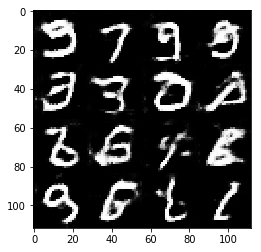

Epoch 1 out of 2
Iteration 710
Discriminator loss: 0.953565
Generator loss: 1.015405
Epoch 1 out of 2
Iteration 720
Discriminator loss: 1.143090
Generator loss: 1.131126
Epoch 1 out of 2
Iteration 730
Discriminator loss: 1.152717
Generator loss: 0.692596
Epoch 1 out of 2
Iteration 740
Discriminator loss: 1.145161
Generator loss: 0.834124
Epoch 1 out of 2
Iteration 750
Discriminator loss: 1.005765
Generator loss: 1.189608
Epoch 1 out of 2
Iteration 760
Discriminator loss: 1.090784
Generator loss: 0.991983
Epoch 1 out of 2
Iteration 770
Discriminator loss: 1.010318
Generator loss: 0.890074
Epoch 1 out of 2
Iteration 780
Discriminator loss: 0.912063
Generator loss: 1.359660
Epoch 1 out of 2
Iteration 790
Discriminator loss: 1.094685
Generator loss: 0.867064
Epoch 1 out of 2
Iteration 800
Discriminator loss: 1.069805
Generator loss: 0.954641


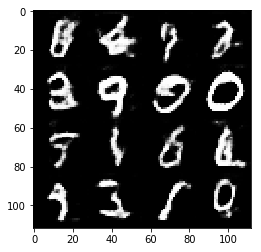

Epoch 1 out of 2
Iteration 810
Discriminator loss: 1.051960
Generator loss: 0.840826
Epoch 1 out of 2
Iteration 820
Discriminator loss: 1.208291
Generator loss: 0.698579
Epoch 1 out of 2
Iteration 830
Discriminator loss: 1.084867
Generator loss: 1.174082
Epoch 1 out of 2
Iteration 840
Discriminator loss: 1.399607
Generator loss: 0.564262
Epoch 1 out of 2
Iteration 850
Discriminator loss: 1.235157
Generator loss: 0.733906
Epoch 1 out of 2
Iteration 860
Discriminator loss: 0.917890
Generator loss: 1.770173
Epoch 1 out of 2
Iteration 870
Discriminator loss: 0.946326
Generator loss: 1.107808
Epoch 1 out of 2
Iteration 880
Discriminator loss: 1.076055
Generator loss: 1.035229
Epoch 1 out of 2
Iteration 890
Discriminator loss: 1.318517
Generator loss: 0.594692
Epoch 1 out of 2
Iteration 900
Discriminator loss: 1.087165
Generator loss: 1.379673


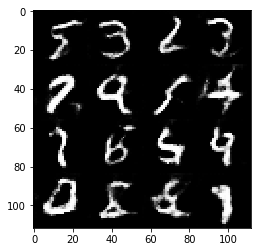

Epoch 1 out of 2
Iteration 910
Discriminator loss: 1.367184
Generator loss: 0.507364
Epoch 1 out of 2
Iteration 920
Discriminator loss: 1.184050
Generator loss: 0.776691
Epoch 1 out of 2
Iteration 930
Discriminator loss: 1.566941
Generator loss: 0.414663
Epoch 1 out of 2
Iteration 940
Discriminator loss: 1.588472
Generator loss: 0.438823
Epoch 1 out of 2
Iteration 950
Discriminator loss: 1.217995
Generator loss: 0.856211
Epoch 1 out of 2
Iteration 960
Discriminator loss: 1.276053
Generator loss: 0.602350
Epoch 1 out of 2
Iteration 970
Discriminator loss: 1.093568
Generator loss: 0.839113
Epoch 1 out of 2
Iteration 980
Discriminator loss: 1.095126
Generator loss: 0.775632
Epoch 1 out of 2
Iteration 990
Discriminator loss: 1.854681
Generator loss: 0.290383
Epoch 1 out of 2
Iteration 1000
Discriminator loss: 1.099707
Generator loss: 0.922658


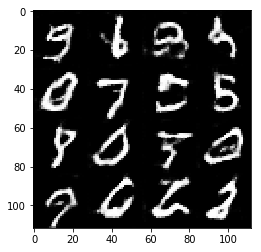

Epoch 1 out of 2
Iteration 1010
Discriminator loss: 0.937092
Generator loss: 1.038390
Epoch 1 out of 2
Iteration 1020
Discriminator loss: 1.161144
Generator loss: 0.719416
Epoch 1 out of 2
Iteration 1030
Discriminator loss: 1.130294
Generator loss: 1.002254
Epoch 1 out of 2
Iteration 1040
Discriminator loss: 0.995444
Generator loss: 1.611441
Epoch 1 out of 2
Iteration 1050
Discriminator loss: 1.109756
Generator loss: 0.798539
Epoch 1 out of 2
Iteration 1060
Discriminator loss: 1.160172
Generator loss: 0.684765
Epoch 1 out of 2
Iteration 1070
Discriminator loss: 0.891261
Generator loss: 1.519273
Epoch 1 out of 2
Iteration 1080
Discriminator loss: 1.157516
Generator loss: 0.921274
Epoch 1 out of 2
Iteration 1090
Discriminator loss: 1.029771
Generator loss: 0.989937
Epoch 1 out of 2
Iteration 1100
Discriminator loss: 1.321339
Generator loss: 0.544294


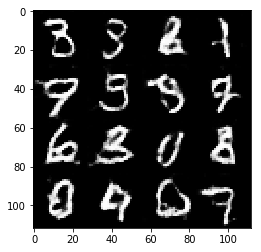

Epoch 1 out of 2
Iteration 1110
Discriminator loss: 1.285130
Generator loss: 0.604971
Epoch 1 out of 2
Iteration 1120
Discriminator loss: 1.046016
Generator loss: 0.827164
Epoch 1 out of 2
Iteration 1130
Discriminator loss: 0.842631
Generator loss: 1.398589
Epoch 1 out of 2
Iteration 1140
Discriminator loss: 1.312928
Generator loss: 0.559473
Epoch 1 out of 2
Iteration 1150
Discriminator loss: 0.898736
Generator loss: 1.338554
Epoch 1 out of 2
Iteration 1160
Discriminator loss: 1.180495
Generator loss: 0.804850
Epoch 1 out of 2
Iteration 1170
Discriminator loss: 1.045111
Generator loss: 0.992336
Epoch 1 out of 2
Iteration 1180
Discriminator loss: 0.918549
Generator loss: 1.014155
Epoch 1 out of 2
Iteration 1190
Discriminator loss: 1.047557
Generator loss: 0.890895
Epoch 1 out of 2
Iteration 1200
Discriminator loss: 0.974786
Generator loss: 0.906234


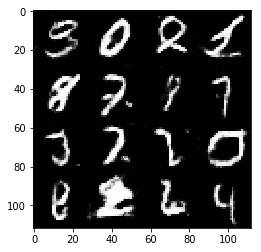

Epoch 1 out of 2
Iteration 1210
Discriminator loss: 1.125788
Generator loss: 1.383531
Epoch 1 out of 2
Iteration 1220
Discriminator loss: 1.016643
Generator loss: 1.033327
Epoch 1 out of 2
Iteration 1230
Discriminator loss: 1.058908
Generator loss: 0.889921
Epoch 1 out of 2
Iteration 1240
Discriminator loss: 1.017455
Generator loss: 0.927350
Epoch 1 out of 2
Iteration 1250
Discriminator loss: 0.992072
Generator loss: 1.011843
Epoch 1 out of 2
Iteration 1260
Discriminator loss: 1.388276
Generator loss: 0.527489
Epoch 1 out of 2
Iteration 1270
Discriminator loss: 1.178220
Generator loss: 1.841991
Epoch 1 out of 2
Iteration 1280
Discriminator loss: 1.177043
Generator loss: 0.685799
Epoch 1 out of 2
Iteration 1290
Discriminator loss: 0.913440
Generator loss: 1.084597
Epoch 1 out of 2
Iteration 1300
Discriminator loss: 0.944662
Generator loss: 0.975550


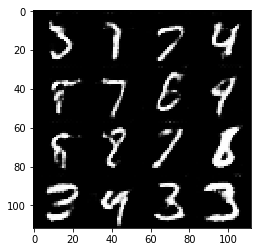

Epoch 1 out of 2
Iteration 1310
Discriminator loss: 1.152516
Generator loss: 0.809137
Epoch 1 out of 2
Iteration 1320
Discriminator loss: 1.078517
Generator loss: 0.756005
Epoch 1 out of 2
Iteration 1330
Discriminator loss: 1.279686
Generator loss: 0.699313
Epoch 1 out of 2
Iteration 1340
Discriminator loss: 1.193002
Generator loss: 0.848619
Epoch 1 out of 2
Iteration 1350
Discriminator loss: 1.143839
Generator loss: 0.702396
Epoch 1 out of 2
Iteration 1360
Discriminator loss: 1.248748
Generator loss: 0.633288
Epoch 1 out of 2
Iteration 1370
Discriminator loss: 1.047428
Generator loss: 0.918562
Epoch 1 out of 2
Iteration 1380
Discriminator loss: 1.023452
Generator loss: 1.057192
Epoch 1 out of 2
Iteration 1390
Discriminator loss: 0.884504
Generator loss: 1.243505
Epoch 1 out of 2
Iteration 1400
Discriminator loss: 1.245275
Generator loss: 0.630482


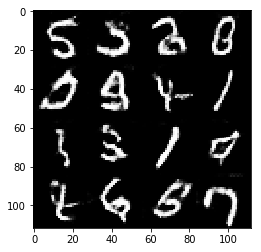

Epoch 1 out of 2
Iteration 1410
Discriminator loss: 0.922741
Generator loss: 1.000824
Epoch 1 out of 2
Iteration 1420
Discriminator loss: 1.165232
Generator loss: 1.794171
Epoch 1 out of 2
Iteration 1430
Discriminator loss: 0.965695
Generator loss: 1.204882
Epoch 1 out of 2
Iteration 1440
Discriminator loss: 0.752747
Generator loss: 1.385430
Epoch 1 out of 2
Iteration 1450
Discriminator loss: 1.105217
Generator loss: 0.811175
Epoch 1 out of 2
Iteration 1460
Discriminator loss: 1.296835
Generator loss: 0.590854
Epoch 1 out of 2
Iteration 1470
Discriminator loss: 1.492852
Generator loss: 0.462968
Epoch 1 out of 2
Iteration 1480
Discriminator loss: 1.148917
Generator loss: 0.832923
Epoch 1 out of 2
Iteration 1490
Discriminator loss: 1.081470
Generator loss: 0.747500
Epoch 1 out of 2
Iteration 1500
Discriminator loss: 1.122428
Generator loss: 1.193544


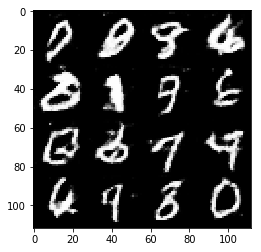

Epoch 1 out of 2
Iteration 1510
Discriminator loss: 0.956760
Generator loss: 1.219528
Epoch 1 out of 2
Iteration 1520
Discriminator loss: 0.976055
Generator loss: 0.870711
Epoch 1 out of 2
Iteration 1530
Discriminator loss: 0.894990
Generator loss: 1.085825
Epoch 1 out of 2
Iteration 1540
Discriminator loss: 1.660050
Generator loss: 0.404424
Epoch 1 out of 2
Iteration 1550
Discriminator loss: 1.044949
Generator loss: 0.882180
Epoch 1 out of 2
Iteration 1560
Discriminator loss: 1.008873
Generator loss: 0.894905
Epoch 1 out of 2
Iteration 1570
Discriminator loss: 1.813136
Generator loss: 0.331047
Epoch 1 out of 2
Iteration 1580
Discriminator loss: 0.789052
Generator loss: 1.307748
Epoch 1 out of 2
Iteration 1590
Discriminator loss: 1.057233
Generator loss: 0.899203
Epoch 1 out of 2
Iteration 1600
Discriminator loss: 0.787265
Generator loss: 1.394845


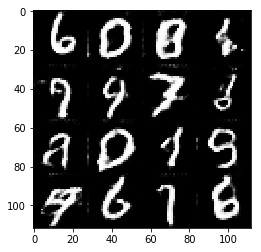

Epoch 1 out of 2
Iteration 1610
Discriminator loss: 1.027961
Generator loss: 1.300903
Epoch 1 out of 2
Iteration 1620
Discriminator loss: 1.179166
Generator loss: 0.701103
Epoch 1 out of 2
Iteration 1630
Discriminator loss: 0.933243
Generator loss: 1.061711
Epoch 1 out of 2
Iteration 1640
Discriminator loss: 0.815454
Generator loss: 1.263750
Epoch 1 out of 2
Iteration 1650
Discriminator loss: 0.854394
Generator loss: 1.384365
Epoch 1 out of 2
Iteration 1660
Discriminator loss: 1.215353
Generator loss: 0.656040
Epoch 1 out of 2
Iteration 1670
Discriminator loss: 1.682375
Generator loss: 0.395477
Epoch 1 out of 2
Iteration 1680
Discriminator loss: 0.964543
Generator loss: 1.064180
Epoch 1 out of 2
Iteration 1690
Discriminator loss: 0.966910
Generator loss: 1.081014
Epoch 1 out of 2
Iteration 1700
Discriminator loss: 0.962497
Generator loss: 1.009849


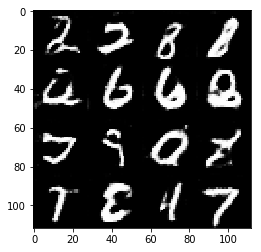

Epoch 1 out of 2
Iteration 1710
Discriminator loss: 1.285419
Generator loss: 0.568147
Epoch 1 out of 2
Iteration 1720
Discriminator loss: 1.043864
Generator loss: 0.792317
Epoch 1 out of 2
Iteration 1730
Discriminator loss: 0.896827
Generator loss: 1.085292
Epoch 1 out of 2
Iteration 1740
Discriminator loss: 0.778023
Generator loss: 1.257759
Epoch 1 out of 2
Iteration 1750
Discriminator loss: 1.073960
Generator loss: 1.261114
Epoch 1 out of 2
Iteration 1760
Discriminator loss: 0.689569
Generator loss: 1.715063
Epoch 1 out of 2
Iteration 1770
Discriminator loss: 1.319017
Generator loss: 0.617547
Epoch 1 out of 2
Iteration 1780
Discriminator loss: 1.053676
Generator loss: 0.868992
Epoch 1 out of 2
Iteration 1790
Discriminator loss: 1.187337
Generator loss: 2.649245
Epoch 1 out of 2
Iteration 1800
Discriminator loss: 1.062375
Generator loss: 0.837708


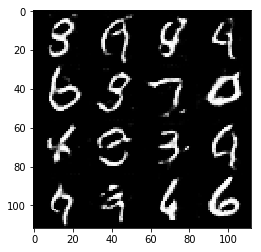

Epoch 1 out of 2
Iteration 1810
Discriminator loss: 1.206765
Generator loss: 0.699187
Epoch 1 out of 2
Iteration 1820
Discriminator loss: 0.903476
Generator loss: 1.130904
Epoch 1 out of 2
Iteration 1830
Discriminator loss: 1.264616
Generator loss: 0.623876
Epoch 1 out of 2
Iteration 1840
Discriminator loss: 1.093524
Generator loss: 0.760733
Epoch 1 out of 2
Iteration 1850
Discriminator loss: 1.186441
Generator loss: 0.704366
Epoch 1 out of 2
Iteration 1860
Discriminator loss: 1.172863
Generator loss: 0.824420
Epoch 1 out of 2
Iteration 1870
Discriminator loss: 1.118494
Generator loss: 0.765131
Epoch 2 out of 2
Iteration 1880
Discriminator loss: 0.901066
Generator loss: 1.030312
Epoch 2 out of 2
Iteration 1890
Discriminator loss: 1.154718
Generator loss: 0.727537
Epoch 2 out of 2
Iteration 1900
Discriminator loss: 1.094364
Generator loss: 0.746941


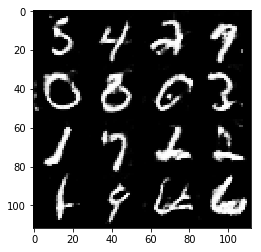

Epoch 2 out of 2
Iteration 1910
Discriminator loss: 0.745364
Generator loss: 1.431522
Epoch 2 out of 2
Iteration 1920
Discriminator loss: 1.012831
Generator loss: 1.380993
Epoch 2 out of 2
Iteration 1930
Discriminator loss: 1.060606
Generator loss: 0.864230
Epoch 2 out of 2
Iteration 1940
Discriminator loss: 1.045302
Generator loss: 1.622604
Epoch 2 out of 2
Iteration 1950
Discriminator loss: 0.866436
Generator loss: 1.808341
Epoch 2 out of 2
Iteration 1960
Discriminator loss: 0.924626
Generator loss: 0.932887
Epoch 2 out of 2
Iteration 1970
Discriminator loss: 1.051682
Generator loss: 0.901832
Epoch 2 out of 2
Iteration 1980
Discriminator loss: 1.775261
Generator loss: 0.396881
Epoch 2 out of 2
Iteration 1990
Discriminator loss: 1.337501
Generator loss: 0.667907
Epoch 2 out of 2
Iteration 2000
Discriminator loss: 0.962335
Generator loss: 1.102277


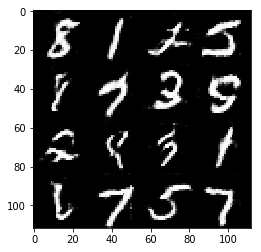

Epoch 2 out of 2
Iteration 2010
Discriminator loss: 0.824919
Generator loss: 1.342985
Epoch 2 out of 2
Iteration 2020
Discriminator loss: 0.896431
Generator loss: 1.216467
Epoch 2 out of 2
Iteration 2030
Discriminator loss: 1.133265
Generator loss: 0.743698
Epoch 2 out of 2
Iteration 2040
Discriminator loss: 1.173623
Generator loss: 0.639067
Epoch 2 out of 2
Iteration 2050
Discriminator loss: 1.568414
Generator loss: 0.475841
Epoch 2 out of 2
Iteration 2060
Discriminator loss: 1.090119
Generator loss: 0.782915
Epoch 2 out of 2
Iteration 2070
Discriminator loss: 1.162366
Generator loss: 0.752363
Epoch 2 out of 2
Iteration 2080
Discriminator loss: 0.917097
Generator loss: 1.909173
Epoch 2 out of 2
Iteration 2090
Discriminator loss: 1.227670
Generator loss: 0.663984
Epoch 2 out of 2
Iteration 2100
Discriminator loss: 1.454795
Generator loss: 0.508559


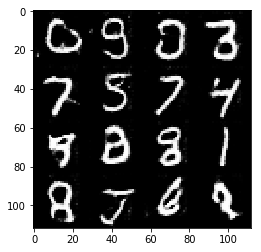

Epoch 2 out of 2
Iteration 2110
Discriminator loss: 0.834312
Generator loss: 1.208994
Epoch 2 out of 2
Iteration 2120
Discriminator loss: 1.283025
Generator loss: 0.641492
Epoch 2 out of 2
Iteration 2130
Discriminator loss: 0.980703
Generator loss: 0.970107
Epoch 2 out of 2
Iteration 2140
Discriminator loss: 1.404336
Generator loss: 0.491091
Epoch 2 out of 2
Iteration 2150
Discriminator loss: 1.026830
Generator loss: 0.829799
Epoch 2 out of 2
Iteration 2160
Discriminator loss: 0.924115
Generator loss: 0.965247
Epoch 2 out of 2
Iteration 2170
Discriminator loss: 1.103681
Generator loss: 0.845384
Epoch 2 out of 2
Iteration 2180
Discriminator loss: 0.998121
Generator loss: 0.820195
Epoch 2 out of 2
Iteration 2190
Discriminator loss: 1.226756
Generator loss: 0.642943
Epoch 2 out of 2
Iteration 2200
Discriminator loss: 0.924951
Generator loss: 1.023691


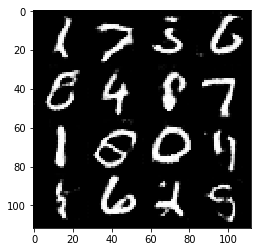

Epoch 2 out of 2
Iteration 2210
Discriminator loss: 1.094797
Generator loss: 0.865477
Epoch 2 out of 2
Iteration 2220
Discriminator loss: 0.929526
Generator loss: 1.775443
Epoch 2 out of 2
Iteration 2230
Discriminator loss: 1.012480
Generator loss: 0.895263
Epoch 2 out of 2
Iteration 2240
Discriminator loss: 0.976437
Generator loss: 0.948089
Epoch 2 out of 2
Iteration 2250
Discriminator loss: 1.331974
Generator loss: 0.570617
Epoch 2 out of 2
Iteration 2260
Discriminator loss: 0.954874
Generator loss: 1.696032
Epoch 2 out of 2
Iteration 2270
Discriminator loss: 0.785929
Generator loss: 1.284605
Epoch 2 out of 2
Iteration 2280
Discriminator loss: 2.207328
Generator loss: 0.221078
Epoch 2 out of 2
Iteration 2290
Discriminator loss: 0.887699
Generator loss: 1.243402
Epoch 2 out of 2
Iteration 2300
Discriminator loss: 1.167228
Generator loss: 0.691467


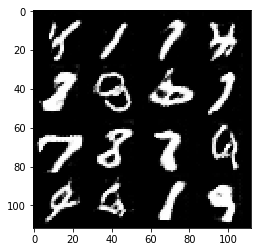

Epoch 2 out of 2
Iteration 2310
Discriminator loss: 0.758375
Generator loss: 1.640103
Epoch 2 out of 2
Iteration 2320
Discriminator loss: 1.218435
Generator loss: 0.659675
Epoch 2 out of 2
Iteration 2330
Discriminator loss: 1.413717
Generator loss: 0.527699
Epoch 2 out of 2
Iteration 2340
Discriminator loss: 0.828203
Generator loss: 1.581390
Epoch 2 out of 2
Iteration 2350
Discriminator loss: 0.880716
Generator loss: 1.230871
Epoch 2 out of 2
Iteration 2360
Discriminator loss: 0.976154
Generator loss: 1.005009
Epoch 2 out of 2
Iteration 2370
Discriminator loss: 0.781026
Generator loss: 1.591964
Epoch 2 out of 2
Iteration 2380
Discriminator loss: 0.981122
Generator loss: 1.000006
Epoch 2 out of 2
Iteration 2390
Discriminator loss: 0.890777
Generator loss: 1.041686
Epoch 2 out of 2
Iteration 2400
Discriminator loss: 0.737632
Generator loss: 1.397084


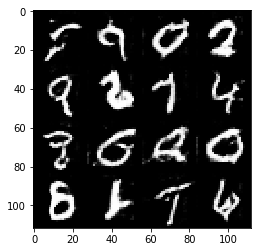

Epoch 2 out of 2
Iteration 2410
Discriminator loss: 1.005025
Generator loss: 1.140912
Epoch 2 out of 2
Iteration 2420
Discriminator loss: 1.298306
Generator loss: 0.587839
Epoch 2 out of 2
Iteration 2430
Discriminator loss: 0.792965
Generator loss: 1.264464
Epoch 2 out of 2
Iteration 2440
Discriminator loss: 1.203229
Generator loss: 0.826473
Epoch 2 out of 2
Iteration 2450
Discriminator loss: 0.892440
Generator loss: 1.094107
Epoch 2 out of 2
Iteration 2460
Discriminator loss: 0.624646
Generator loss: 2.006467
Epoch 2 out of 2
Iteration 2470
Discriminator loss: 0.942489
Generator loss: 0.956620
Epoch 2 out of 2
Iteration 2480
Discriminator loss: 1.364294
Generator loss: 0.560139
Epoch 2 out of 2
Iteration 2490
Discriminator loss: 1.103131
Generator loss: 0.802800
Epoch 2 out of 2
Iteration 2500
Discriminator loss: 0.851676
Generator loss: 1.342998


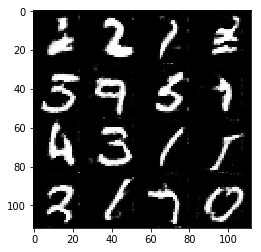

Epoch 2 out of 2
Iteration 2510
Discriminator loss: 0.831478
Generator loss: 1.521210
Epoch 2 out of 2
Iteration 2520
Discriminator loss: 1.760531
Generator loss: 3.094336
Epoch 2 out of 2
Iteration 2530
Discriminator loss: 0.799220
Generator loss: 1.355704
Epoch 2 out of 2
Iteration 2540
Discriminator loss: 1.078027
Generator loss: 0.813071
Epoch 2 out of 2
Iteration 2550
Discriminator loss: 1.033325
Generator loss: 0.807969
Epoch 2 out of 2
Iteration 2560
Discriminator loss: 1.058336
Generator loss: 0.817255
Epoch 2 out of 2
Iteration 2570
Discriminator loss: 0.953538
Generator loss: 0.944743
Epoch 2 out of 2
Iteration 2580
Discriminator loss: 0.846981
Generator loss: 1.498263
Epoch 2 out of 2
Iteration 2590
Discriminator loss: 0.867466
Generator loss: 1.844753
Epoch 2 out of 2
Iteration 2600
Discriminator loss: 0.868803
Generator loss: 1.113406


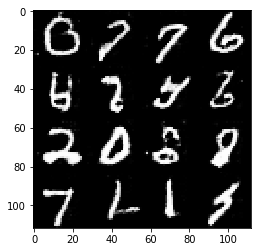

Epoch 2 out of 2
Iteration 2610
Discriminator loss: 1.068083
Generator loss: 1.672372
Epoch 2 out of 2
Iteration 2620
Discriminator loss: 1.471784
Generator loss: 0.448744
Epoch 2 out of 2
Iteration 2630
Discriminator loss: 1.226513
Generator loss: 0.670668
Epoch 2 out of 2
Iteration 2640
Discriminator loss: 0.741024
Generator loss: 1.470922
Epoch 2 out of 2
Iteration 2650
Discriminator loss: 1.023485
Generator loss: 1.143057
Epoch 2 out of 2
Iteration 2660
Discriminator loss: 1.082412
Generator loss: 0.879865
Epoch 2 out of 2
Iteration 2670
Discriminator loss: 0.810366
Generator loss: 1.606004
Epoch 2 out of 2
Iteration 2680
Discriminator loss: 0.835720
Generator loss: 1.538970
Epoch 2 out of 2
Iteration 2690
Discriminator loss: 0.797141
Generator loss: 1.216795
Epoch 2 out of 2
Iteration 2700
Discriminator loss: 1.017424
Generator loss: 2.996279


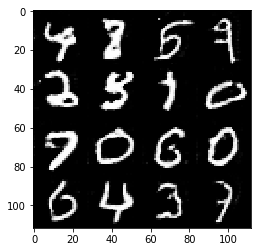

Epoch 2 out of 2
Iteration 2710
Discriminator loss: 0.677505
Generator loss: 1.939396
Epoch 2 out of 2
Iteration 2720
Discriminator loss: 0.836611
Generator loss: 1.200613
Epoch 2 out of 2
Iteration 2730
Discriminator loss: 0.900360
Generator loss: 1.136622
Epoch 2 out of 2
Iteration 2740
Discriminator loss: 0.828774
Generator loss: 1.358834
Epoch 2 out of 2
Iteration 2750
Discriminator loss: 0.969649
Generator loss: 0.966951
Epoch 2 out of 2
Iteration 2760
Discriminator loss: 0.664686
Generator loss: 1.876929
Epoch 2 out of 2
Iteration 2770
Discriminator loss: 1.059785
Generator loss: 0.792947
Epoch 2 out of 2
Iteration 2780
Discriminator loss: 0.990705
Generator loss: 0.918419
Epoch 2 out of 2
Iteration 2790
Discriminator loss: 0.936173
Generator loss: 0.952065
Epoch 2 out of 2
Iteration 2800
Discriminator loss: 1.183332
Generator loss: 0.666686


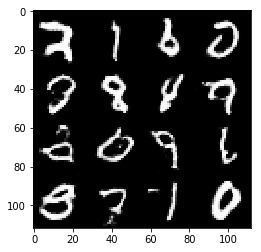

Epoch 2 out of 2
Iteration 2810
Discriminator loss: 0.804094
Generator loss: 1.373822
Epoch 2 out of 2
Iteration 2820
Discriminator loss: 0.754696
Generator loss: 1.440413
Epoch 2 out of 2
Iteration 2830
Discriminator loss: 0.752520
Generator loss: 1.256199
Epoch 2 out of 2
Iteration 2840
Discriminator loss: 0.661371
Generator loss: 1.613757
Epoch 2 out of 2
Iteration 2850
Discriminator loss: 0.844643
Generator loss: 1.107434
Epoch 2 out of 2
Iteration 2860
Discriminator loss: 1.803858
Generator loss: 3.096932
Epoch 2 out of 2
Iteration 2870
Discriminator loss: 0.676424
Generator loss: 1.756718
Epoch 2 out of 2
Iteration 2880
Discriminator loss: 1.079554
Generator loss: 0.816606
Epoch 2 out of 2
Iteration 2890
Discriminator loss: 1.119600
Generator loss: 0.714314
Epoch 2 out of 2
Iteration 2900
Discriminator loss: 0.726471
Generator loss: 1.507406


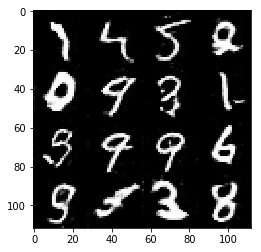

Epoch 2 out of 2
Iteration 2910
Discriminator loss: 0.677075
Generator loss: 1.491076
Epoch 2 out of 2
Iteration 2920
Discriminator loss: 0.777044
Generator loss: 1.260771
Epoch 2 out of 2
Iteration 2930
Discriminator loss: 1.092294
Generator loss: 0.725297
Epoch 2 out of 2
Iteration 2940
Discriminator loss: 0.708277
Generator loss: 1.725607
Epoch 2 out of 2
Iteration 2950
Discriminator loss: 0.905654
Generator loss: 0.992040
Epoch 2 out of 2
Iteration 2960
Discriminator loss: 1.211874
Generator loss: 0.609531
Epoch 2 out of 2
Iteration 2970
Discriminator loss: 0.867176
Generator loss: 1.824099
Epoch 2 out of 2
Iteration 2980
Discriminator loss: 0.903110
Generator loss: 1.925668
Epoch 2 out of 2
Iteration 2990
Discriminator loss: 0.869704
Generator loss: 1.309639
Epoch 2 out of 2
Iteration 3000
Discriminator loss: 1.089392
Generator loss: 0.826543


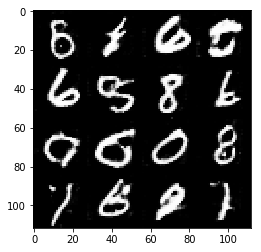

Epoch 2 out of 2
Iteration 3010
Discriminator loss: 0.937937
Generator loss: 1.162990
Epoch 2 out of 2
Iteration 3020
Discriminator loss: 1.036887
Generator loss: 0.818561
Epoch 2 out of 2
Iteration 3030
Discriminator loss: 0.792260
Generator loss: 1.266539
Epoch 2 out of 2
Iteration 3040
Discriminator loss: 0.869589
Generator loss: 1.806195
Epoch 2 out of 2
Iteration 3050
Discriminator loss: 0.751717
Generator loss: 1.416737
Epoch 2 out of 2
Iteration 3060
Discriminator loss: 1.084893
Generator loss: 0.775498
Epoch 2 out of 2
Iteration 3070
Discriminator loss: 0.700596
Generator loss: 1.796428
Epoch 2 out of 2
Iteration 3080
Discriminator loss: 0.878180
Generator loss: 1.006991
Epoch 2 out of 2
Iteration 3090
Discriminator loss: 1.594646
Generator loss: 3.273612
Epoch 2 out of 2
Iteration 3100
Discriminator loss: 1.301720
Generator loss: 0.638467


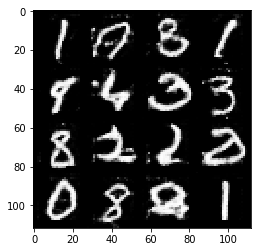

Epoch 2 out of 2
Iteration 3110
Discriminator loss: 0.818361
Generator loss: 1.233299
Epoch 2 out of 2
Iteration 3120
Discriminator loss: 0.908632
Generator loss: 1.059055
Epoch 2 out of 2
Iteration 3130
Discriminator loss: 0.944600
Generator loss: 0.994642
Epoch 2 out of 2
Iteration 3140
Discriminator loss: 1.017880
Generator loss: 0.853283
Epoch 2 out of 2
Iteration 3150
Discriminator loss: 0.850172
Generator loss: 1.103059
Epoch 2 out of 2
Iteration 3160
Discriminator loss: 0.754947
Generator loss: 1.623251
Epoch 2 out of 2
Iteration 3170
Discriminator loss: 1.193186
Generator loss: 0.662508
Epoch 2 out of 2
Iteration 3180
Discriminator loss: 1.103690
Generator loss: 0.817748
Epoch 2 out of 2
Iteration 3190
Discriminator loss: 1.341816
Generator loss: 0.584588
Epoch 2 out of 2
Iteration 3200
Discriminator loss: 0.678527
Generator loss: 1.678051


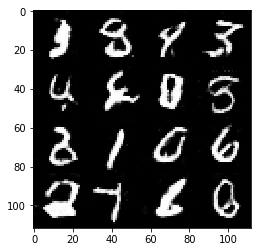

Epoch 2 out of 2
Iteration 3210
Discriminator loss: 0.957475
Generator loss: 0.957283
Epoch 2 out of 2
Iteration 3220
Discriminator loss: 0.840372
Generator loss: 1.182927
Epoch 2 out of 2
Iteration 3230
Discriminator loss: 1.103657
Generator loss: 2.614297
Epoch 2 out of 2
Iteration 3240
Discriminator loss: 0.966555
Generator loss: 0.999734
Epoch 2 out of 2
Iteration 3250
Discriminator loss: 0.898444
Generator loss: 1.099698
Epoch 2 out of 2
Iteration 3260
Discriminator loss: 0.765637
Generator loss: 1.207275
Epoch 2 out of 2
Iteration 3270
Discriminator loss: 0.955969
Generator loss: 1.195200
Epoch 2 out of 2
Iteration 3280
Discriminator loss: 0.772572
Generator loss: 1.397287
Epoch 2 out of 2
Iteration 3290
Discriminator loss: 0.811194
Generator loss: 1.184921
Epoch 2 out of 2
Iteration 3300
Discriminator loss: 0.745109
Generator loss: 1.316326


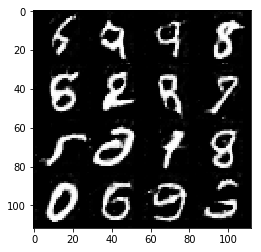

Epoch 2 out of 2
Iteration 3310
Discriminator loss: 0.974129
Generator loss: 0.910972
Epoch 2 out of 2
Iteration 3320
Discriminator loss: 0.877464
Generator loss: 1.110866
Epoch 2 out of 2
Iteration 3330
Discriminator loss: 1.440299
Generator loss: 0.495371
Epoch 2 out of 2
Iteration 3340
Discriminator loss: 1.279001
Generator loss: 0.600450
Epoch 2 out of 2
Iteration 3350
Discriminator loss: 1.030310
Generator loss: 0.923065
Epoch 2 out of 2
Iteration 3360
Discriminator loss: 0.768480
Generator loss: 1.543864
Epoch 2 out of 2
Iteration 3370
Discriminator loss: 0.978426
Generator loss: 0.879116
Epoch 2 out of 2
Iteration 3380
Discriminator loss: 0.813067
Generator loss: 1.274551
Epoch 2 out of 2
Iteration 3390
Discriminator loss: 0.890242
Generator loss: 1.122586
Epoch 2 out of 2
Iteration 3400
Discriminator loss: 1.079312
Generator loss: 0.866375


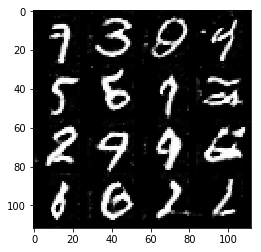

Epoch 2 out of 2
Iteration 3410
Discriminator loss: 0.818272
Generator loss: 1.274089
Epoch 2 out of 2
Iteration 3420
Discriminator loss: 1.513373
Generator loss: 0.545889
Epoch 2 out of 2
Iteration 3430
Discriminator loss: 0.610937
Generator loss: 1.880644
Epoch 2 out of 2
Iteration 3440
Discriminator loss: 0.860718
Generator loss: 1.123265
Epoch 2 out of 2
Iteration 3450
Discriminator loss: 0.780856
Generator loss: 1.350305
Epoch 2 out of 2
Iteration 3460
Discriminator loss: 0.962087
Generator loss: 0.897810
Epoch 2 out of 2
Iteration 3470
Discriminator loss: 0.972518
Generator loss: 0.985038
Epoch 2 out of 2
Iteration 3480
Discriminator loss: 0.771568
Generator loss: 1.304064
Epoch 2 out of 2
Iteration 3490
Discriminator loss: 0.851804
Generator loss: 1.260448
Epoch 2 out of 2
Iteration 3500
Discriminator loss: 0.957308
Generator loss: 0.988087


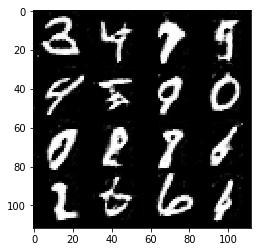

Epoch 2 out of 2
Iteration 3510
Discriminator loss: 1.066103
Generator loss: 0.935803
Epoch 2 out of 2
Iteration 3520
Discriminator loss: 0.734818
Generator loss: 1.315937
Epoch 2 out of 2
Iteration 3530
Discriminator loss: 1.007474
Generator loss: 0.946083
Epoch 2 out of 2
Iteration 3540
Discriminator loss: 1.270074
Generator loss: 0.689645
Epoch 2 out of 2
Iteration 3550
Discriminator loss: 1.046456
Generator loss: 0.911701
Epoch 2 out of 2
Iteration 3560
Discriminator loss: 1.246024
Generator loss: 0.660761
Epoch 2 out of 2
Iteration 3570
Discriminator loss: 0.714767
Generator loss: 1.359571
Epoch 2 out of 2
Iteration 3580
Discriminator loss: 0.748853
Generator loss: 1.536255
Epoch 2 out of 2
Iteration 3590
Discriminator loss: 0.646544
Generator loss: 1.865455
Epoch 2 out of 2
Iteration 3600
Discriminator loss: 0.687320
Generator loss: 1.456910


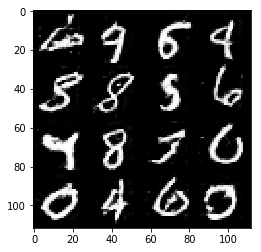

Epoch 2 out of 2
Iteration 3610
Discriminator loss: 0.934922
Generator loss: 0.977021
Epoch 2 out of 2
Iteration 3620
Discriminator loss: 0.664989
Generator loss: 1.556051
Epoch 2 out of 2
Iteration 3630
Discriminator loss: 1.060433
Generator loss: 0.839279
Epoch 2 out of 2
Iteration 3640
Discriminator loss: 0.964181
Generator loss: 0.969463
Epoch 2 out of 2
Iteration 3650
Discriminator loss: 0.662074
Generator loss: 1.493473
Epoch 2 out of 2
Iteration 3660
Discriminator loss: 0.652898
Generator loss: 2.004190
Epoch 2 out of 2
Iteration 3670
Discriminator loss: 1.204217
Generator loss: 0.656865
Epoch 2 out of 2
Iteration 3680
Discriminator loss: 0.697303
Generator loss: 2.043005
Epoch 2 out of 2
Iteration 3690
Discriminator loss: 1.291578
Generator loss: 0.603243
Epoch 2 out of 2
Iteration 3700
Discriminator loss: 0.944522
Generator loss: 1.087492


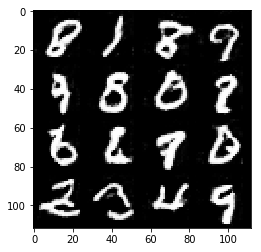

Epoch 2 out of 2
Iteration 3710
Discriminator loss: 0.699956
Generator loss: 1.649643
Epoch 2 out of 2
Iteration 3720
Discriminator loss: 0.721869
Generator loss: 1.304482
Epoch 2 out of 2
Iteration 3730
Discriminator loss: 0.666876
Generator loss: 1.605646
Epoch 2 out of 2
Iteration 3740
Discriminator loss: 1.151505
Generator loss: 0.711419
Epoch 2 out of 2
Iteration 3750
Discriminator loss: 0.807801
Generator loss: 1.276599


In [112]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1 out of 1
Iteration 10
Discriminator loss: 0.585675
Generator loss: 1.928126
Epoch 1 out of 1
Iteration 20
Discriminator loss: 0.567262
Generator loss: 1.850693
Epoch 1 out of 1
Iteration 30
Discriminator loss: 0.697579
Generator loss: 1.561060
Epoch 1 out of 1
Iteration 40
Discriminator loss: 0.545341
Generator loss: 2.253112
Epoch 1 out of 1
Iteration 50
Discriminator loss: 0.549721
Generator loss: 3.253524
Epoch 1 out of 1
Iteration 60
Discriminator loss: 0.951008
Generator loss: 1.004162
Epoch 1 out of 1
Iteration 70
Discriminator loss: 1.464479
Generator loss: 0.524907
Epoch 1 out of 1
Iteration 80
Discriminator loss: 0.547022
Generator loss: 2.993188
Epoch 1 out of 1
Iteration 90
Discriminator loss: 1.786187
Generator loss: 4.920390
Epoch 1 out of 1
Iteration 100
Discriminator loss: 1.044529
Generator loss: 0.909313


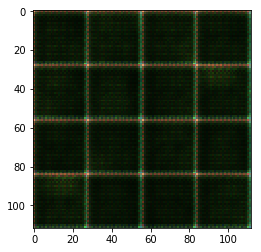

Epoch 1 out of 1
Iteration 110
Discriminator loss: 1.373185
Generator loss: 0.565261
Epoch 1 out of 1
Iteration 120
Discriminator loss: 0.556813
Generator loss: 2.036618
Epoch 1 out of 1
Iteration 130
Discriminator loss: 1.735349
Generator loss: 0.394375
Epoch 1 out of 1
Iteration 140
Discriminator loss: 0.414520
Generator loss: 3.490879
Epoch 1 out of 1
Iteration 150
Discriminator loss: 0.608326
Generator loss: 3.386179
Epoch 1 out of 1
Iteration 160
Discriminator loss: 0.954715
Generator loss: 2.887143
Epoch 1 out of 1
Iteration 170
Discriminator loss: 0.856478
Generator loss: 1.160206
Epoch 1 out of 1
Iteration 180
Discriminator loss: 1.062853
Generator loss: 0.917827
Epoch 1 out of 1
Iteration 190
Discriminator loss: 0.556538
Generator loss: 2.012456
Epoch 1 out of 1
Iteration 200
Discriminator loss: 1.027529
Generator loss: 4.466105


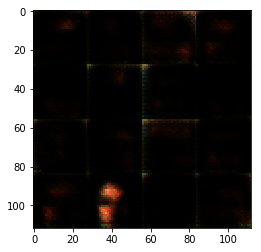

Epoch 1 out of 1
Iteration 210
Discriminator loss: 0.533776
Generator loss: 2.511285
Epoch 1 out of 1
Iteration 220
Discriminator loss: 0.764948
Generator loss: 1.230315
Epoch 1 out of 1
Iteration 230
Discriminator loss: 0.754865
Generator loss: 1.602172
Epoch 1 out of 1
Iteration 240
Discriminator loss: 0.989957
Generator loss: 0.978836
Epoch 1 out of 1
Iteration 250
Discriminator loss: 1.329724
Generator loss: 0.588562
Epoch 1 out of 1
Iteration 260
Discriminator loss: 0.448886
Generator loss: 3.181731
Epoch 1 out of 1
Iteration 270
Discriminator loss: 1.456116
Generator loss: 0.540938
Epoch 1 out of 1
Iteration 280
Discriminator loss: 0.820442
Generator loss: 1.400901
Epoch 1 out of 1
Iteration 290
Discriminator loss: 0.993317
Generator loss: 1.278671
Epoch 1 out of 1
Iteration 300
Discriminator loss: 0.752999
Generator loss: 1.598468


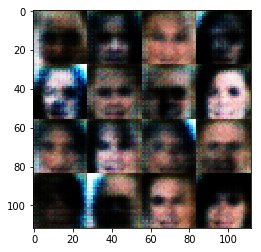

Epoch 1 out of 1
Iteration 310
Discriminator loss: 0.688111
Generator loss: 1.734839
Epoch 1 out of 1
Iteration 320
Discriminator loss: 0.769331
Generator loss: 1.319299
Epoch 1 out of 1
Iteration 330
Discriminator loss: 0.595598
Generator loss: 3.860535
Epoch 1 out of 1
Iteration 340
Discriminator loss: 0.766657
Generator loss: 3.142189
Epoch 1 out of 1
Iteration 350
Discriminator loss: 1.255337
Generator loss: 0.668393
Epoch 1 out of 1
Iteration 360
Discriminator loss: 0.637720
Generator loss: 2.708845
Epoch 1 out of 1
Iteration 370
Discriminator loss: 0.894657
Generator loss: 1.257419
Epoch 1 out of 1
Iteration 380
Discriminator loss: 3.075403
Generator loss: 0.089183
Epoch 1 out of 1
Iteration 390
Discriminator loss: 0.884513
Generator loss: 4.697866
Epoch 1 out of 1
Iteration 400
Discriminator loss: 0.783761
Generator loss: 1.254774


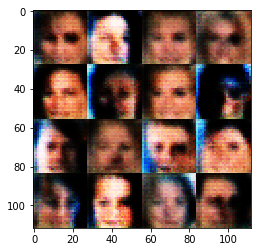

Epoch 1 out of 1
Iteration 410
Discriminator loss: 1.771546
Generator loss: 0.371339
Epoch 1 out of 1
Iteration 420
Discriminator loss: 0.881461
Generator loss: 2.541158
Epoch 1 out of 1
Iteration 430
Discriminator loss: 1.672755
Generator loss: 0.399737
Epoch 1 out of 1
Iteration 440
Discriminator loss: 1.212635
Generator loss: 0.818321
Epoch 1 out of 1
Iteration 450
Discriminator loss: 1.225348
Generator loss: 0.663948
Epoch 1 out of 1
Iteration 460
Discriminator loss: 1.418682
Generator loss: 2.657962
Epoch 1 out of 1
Iteration 470
Discriminator loss: 1.677522
Generator loss: 2.106519
Epoch 1 out of 1
Iteration 480
Discriminator loss: 0.486437
Generator loss: 2.580418
Epoch 1 out of 1
Iteration 490
Discriminator loss: 1.787461
Generator loss: 0.326957
Epoch 1 out of 1
Iteration 500
Discriminator loss: 1.209284
Generator loss: 1.629944


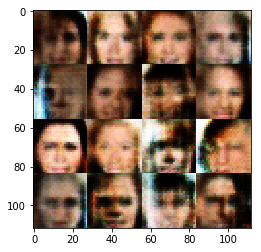

Epoch 1 out of 1
Iteration 510
Discriminator loss: 0.844567
Generator loss: 2.714203
Epoch 1 out of 1
Iteration 520
Discriminator loss: 1.037397
Generator loss: 1.074880
Epoch 1 out of 1
Iteration 530
Discriminator loss: 0.803757
Generator loss: 2.494380
Epoch 1 out of 1
Iteration 540
Discriminator loss: 0.822555
Generator loss: 1.116884
Epoch 1 out of 1
Iteration 550
Discriminator loss: 0.897655
Generator loss: 1.121051
Epoch 1 out of 1
Iteration 560
Discriminator loss: 1.417051
Generator loss: 2.165668
Epoch 1 out of 1
Iteration 570
Discriminator loss: 0.579805
Generator loss: 2.521222
Epoch 1 out of 1
Iteration 580
Discriminator loss: 1.119007
Generator loss: 1.349430
Epoch 1 out of 1
Iteration 590
Discriminator loss: 1.011913
Generator loss: 1.028684
Epoch 1 out of 1
Iteration 600
Discriminator loss: 0.787457
Generator loss: 1.822350


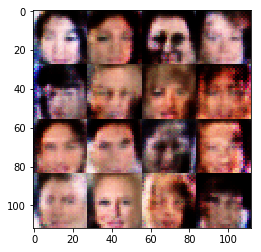

Epoch 1 out of 1
Iteration 610
Discriminator loss: 0.782714
Generator loss: 1.231070
Epoch 1 out of 1
Iteration 620
Discriminator loss: 0.561465
Generator loss: 1.913313
Epoch 1 out of 1
Iteration 630
Discriminator loss: 0.667084
Generator loss: 1.705592
Epoch 1 out of 1
Iteration 640
Discriminator loss: 0.960547
Generator loss: 2.276667
Epoch 1 out of 1
Iteration 650
Discriminator loss: 0.769280
Generator loss: 1.503687
Epoch 1 out of 1
Iteration 660
Discriminator loss: 0.847660
Generator loss: 1.330534
Epoch 1 out of 1
Iteration 670
Discriminator loss: 0.698188
Generator loss: 1.378325
Epoch 1 out of 1
Iteration 680
Discriminator loss: 0.764866
Generator loss: 1.363513
Epoch 1 out of 1
Iteration 690
Discriminator loss: 1.998492
Generator loss: 0.252357
Epoch 1 out of 1
Iteration 700
Discriminator loss: 1.071553
Generator loss: 1.053640


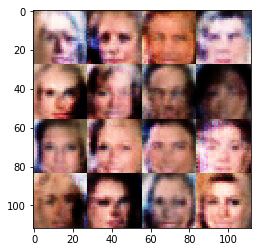

Epoch 1 out of 1
Iteration 710
Discriminator loss: 0.672883
Generator loss: 1.581026
Epoch 1 out of 1
Iteration 720
Discriminator loss: 0.695825
Generator loss: 1.450899
Epoch 1 out of 1
Iteration 730
Discriminator loss: 0.876191
Generator loss: 1.210304
Epoch 1 out of 1
Iteration 740
Discriminator loss: 0.616012
Generator loss: 1.933006
Epoch 1 out of 1
Iteration 750
Discriminator loss: 1.062070
Generator loss: 0.899615
Epoch 1 out of 1
Iteration 760
Discriminator loss: 0.759549
Generator loss: 1.632520
Epoch 1 out of 1
Iteration 770
Discriminator loss: 0.894277
Generator loss: 3.599527
Epoch 1 out of 1
Iteration 780
Discriminator loss: 1.114531
Generator loss: 0.822328
Epoch 1 out of 1
Iteration 790
Discriminator loss: 0.564791
Generator loss: 4.299247
Epoch 1 out of 1
Iteration 800
Discriminator loss: 1.231446
Generator loss: 0.720293


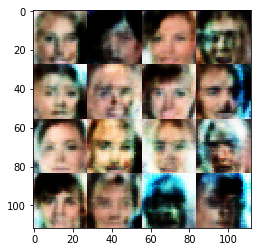

Epoch 1 out of 1
Iteration 810
Discriminator loss: 0.729627
Generator loss: 2.188082
Epoch 1 out of 1
Iteration 820
Discriminator loss: 0.525578
Generator loss: 2.465859
Epoch 1 out of 1
Iteration 830
Discriminator loss: 0.594195
Generator loss: 2.271493
Epoch 1 out of 1
Iteration 840
Discriminator loss: 0.871326
Generator loss: 1.230813
Epoch 1 out of 1
Iteration 850
Discriminator loss: 0.784191
Generator loss: 1.444918
Epoch 1 out of 1
Iteration 860
Discriminator loss: 1.266323
Generator loss: 2.370671
Epoch 1 out of 1
Iteration 870
Discriminator loss: 2.778251
Generator loss: 0.111502
Epoch 1 out of 1
Iteration 880
Discriminator loss: 1.100760
Generator loss: 0.746643
Epoch 1 out of 1
Iteration 890
Discriminator loss: 0.758176
Generator loss: 4.594873
Epoch 1 out of 1
Iteration 900
Discriminator loss: 1.142859
Generator loss: 0.689691


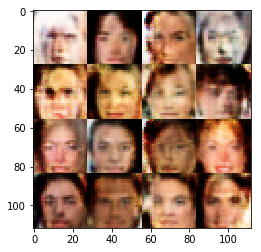

Epoch 1 out of 1
Iteration 910
Discriminator loss: 0.890628
Generator loss: 1.226312
Epoch 1 out of 1
Iteration 920
Discriminator loss: 1.088360
Generator loss: 0.768593
Epoch 1 out of 1
Iteration 930
Discriminator loss: 0.849389
Generator loss: 3.824271
Epoch 1 out of 1
Iteration 940
Discriminator loss: 0.897332
Generator loss: 2.657597
Epoch 1 out of 1
Iteration 950
Discriminator loss: 1.045468
Generator loss: 0.849472
Epoch 1 out of 1
Iteration 960
Discriminator loss: 0.971151
Generator loss: 1.509142
Epoch 1 out of 1
Iteration 970
Discriminator loss: 2.106474
Generator loss: 0.232669
Epoch 1 out of 1
Iteration 980
Discriminator loss: 1.120748
Generator loss: 0.758032
Epoch 1 out of 1
Iteration 990
Discriminator loss: 1.491256
Generator loss: 0.442886
Epoch 1 out of 1
Iteration 1000
Discriminator loss: 0.963644
Generator loss: 1.033987


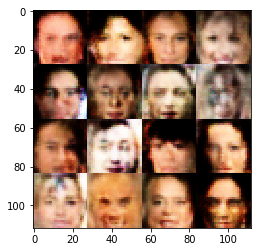

Epoch 1 out of 1
Iteration 1010
Discriminator loss: 1.111893
Generator loss: 0.756308
Epoch 1 out of 1
Iteration 1020
Discriminator loss: 1.699380
Generator loss: 0.380064
Epoch 1 out of 1
Iteration 1030
Discriminator loss: 0.817121
Generator loss: 1.423789
Epoch 1 out of 1
Iteration 1040
Discriminator loss: 1.004258
Generator loss: 0.838963
Epoch 1 out of 1
Iteration 1050
Discriminator loss: 1.336720
Generator loss: 2.299499
Epoch 1 out of 1
Iteration 1060
Discriminator loss: 1.070759
Generator loss: 0.781740
Epoch 1 out of 1
Iteration 1070
Discriminator loss: 1.036530
Generator loss: 0.916608
Epoch 1 out of 1
Iteration 1080
Discriminator loss: 0.834480
Generator loss: 1.032493
Epoch 1 out of 1
Iteration 1090
Discriminator loss: 1.416783
Generator loss: 0.456624
Epoch 1 out of 1
Iteration 1100
Discriminator loss: 0.909219
Generator loss: 1.060601


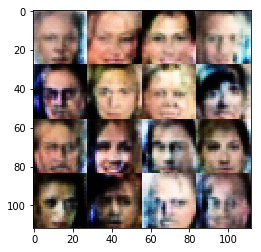

Epoch 1 out of 1
Iteration 1110
Discriminator loss: 0.552408
Generator loss: 2.438947
Epoch 1 out of 1
Iteration 1120
Discriminator loss: 0.693878
Generator loss: 1.618498
Epoch 1 out of 1
Iteration 1130
Discriminator loss: 1.192620
Generator loss: 0.703911
Epoch 1 out of 1
Iteration 1140
Discriminator loss: 1.545079
Generator loss: 0.394615
Epoch 1 out of 1
Iteration 1150
Discriminator loss: 0.891128
Generator loss: 0.996260
Epoch 1 out of 1
Iteration 1160
Discriminator loss: 0.553807
Generator loss: 3.183320
Epoch 1 out of 1
Iteration 1170
Discriminator loss: 0.995243
Generator loss: 1.978986
Epoch 1 out of 1
Iteration 1180
Discriminator loss: 0.847778
Generator loss: 1.491794
Epoch 1 out of 1
Iteration 1190
Discriminator loss: 0.613039
Generator loss: 1.726951
Epoch 1 out of 1
Iteration 1200
Discriminator loss: 0.381207
Generator loss: 3.621882


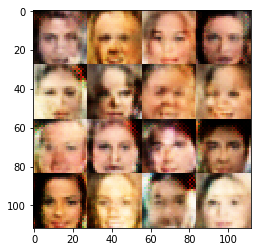

Epoch 1 out of 1
Iteration 1210
Discriminator loss: 1.867220
Generator loss: 0.273725
Epoch 1 out of 1
Iteration 1220
Discriminator loss: 0.884893
Generator loss: 1.150265
Epoch 1 out of 1
Iteration 1230
Discriminator loss: 1.006214
Generator loss: 0.828158
Epoch 1 out of 1
Iteration 1240
Discriminator loss: 0.716301
Generator loss: 1.532205
Epoch 1 out of 1
Iteration 1250
Discriminator loss: 1.418147
Generator loss: 0.462098
Epoch 1 out of 1
Iteration 1260
Discriminator loss: 1.024508
Generator loss: 1.015122
Epoch 1 out of 1
Iteration 1270
Discriminator loss: 0.935650
Generator loss: 3.139360
Epoch 1 out of 1
Iteration 1280
Discriminator loss: 0.953566
Generator loss: 1.027415
Epoch 1 out of 1
Iteration 1290
Discriminator loss: 1.061143
Generator loss: 0.956469
Epoch 1 out of 1
Iteration 1300
Discriminator loss: 1.274939
Generator loss: 0.653079


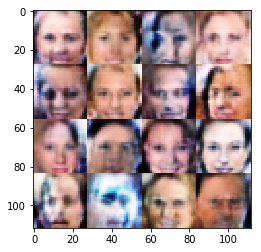

Epoch 1 out of 1
Iteration 1310
Discriminator loss: 0.755687
Generator loss: 1.310923
Epoch 1 out of 1
Iteration 1320
Discriminator loss: 0.746521
Generator loss: 1.542324
Epoch 1 out of 1
Iteration 1330
Discriminator loss: 1.398142
Generator loss: 2.329388
Epoch 1 out of 1
Iteration 1340
Discriminator loss: 0.637211
Generator loss: 2.617105
Epoch 1 out of 1
Iteration 1350
Discriminator loss: 0.469754
Generator loss: 3.692536
Epoch 1 out of 1
Iteration 1360
Discriminator loss: 1.589319
Generator loss: 0.933779
Epoch 1 out of 1
Iteration 1370
Discriminator loss: 1.318549
Generator loss: 0.916999
Epoch 1 out of 1
Iteration 1380
Discriminator loss: 0.868781
Generator loss: 1.107745
Epoch 1 out of 1
Iteration 1390
Discriminator loss: 0.708031
Generator loss: 1.600365
Epoch 1 out of 1
Iteration 1400
Discriminator loss: 1.119533
Generator loss: 0.700824


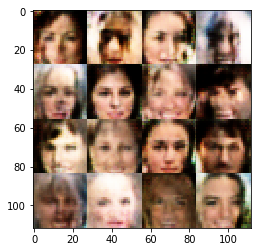

Epoch 1 out of 1
Iteration 1410
Discriminator loss: 0.511360
Generator loss: 2.675767
Epoch 1 out of 1
Iteration 1420
Discriminator loss: 1.212919
Generator loss: 1.018132
Epoch 1 out of 1
Iteration 1430
Discriminator loss: 2.431484
Generator loss: 0.162134
Epoch 1 out of 1
Iteration 1440
Discriminator loss: 0.694436
Generator loss: 1.632397
Epoch 1 out of 1
Iteration 1450
Discriminator loss: 0.692159
Generator loss: 1.584464
Epoch 1 out of 1
Iteration 1460
Discriminator loss: 1.207944
Generator loss: 1.861417
Epoch 1 out of 1
Iteration 1470
Discriminator loss: 0.787055
Generator loss: 1.378368
Epoch 1 out of 1
Iteration 1480
Discriminator loss: 1.339225
Generator loss: 0.909307
Epoch 1 out of 1
Iteration 1490
Discriminator loss: 1.095169
Generator loss: 1.563181
Epoch 1 out of 1
Iteration 1500
Discriminator loss: 1.098724
Generator loss: 0.711834


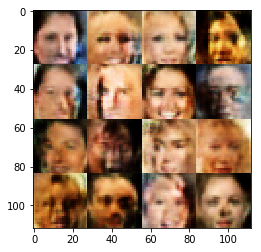

Epoch 1 out of 1
Iteration 1510
Discriminator loss: 1.533334
Generator loss: 0.401969
Epoch 1 out of 1
Iteration 1520
Discriminator loss: 0.777530
Generator loss: 1.369300
Epoch 1 out of 1
Iteration 1530
Discriminator loss: 1.734496
Generator loss: 0.342066
Epoch 1 out of 1
Iteration 1540
Discriminator loss: 0.724590
Generator loss: 1.369402
Epoch 1 out of 1
Iteration 1550
Discriminator loss: 0.841585
Generator loss: 1.563478
Epoch 1 out of 1
Iteration 1560
Discriminator loss: 0.493966
Generator loss: 2.575626
Epoch 1 out of 1
Iteration 1570
Discriminator loss: 1.562231
Generator loss: 3.510608
Epoch 1 out of 1
Iteration 1580
Discriminator loss: 0.889298
Generator loss: 4.475933
Epoch 1 out of 1
Iteration 1590
Discriminator loss: 0.763888
Generator loss: 1.751296
Epoch 1 out of 1
Iteration 1600
Discriminator loss: 0.751739
Generator loss: 2.406839


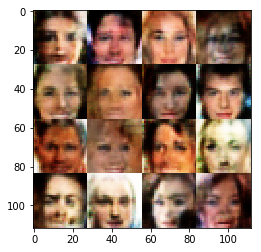

Epoch 1 out of 1
Iteration 1610
Discriminator loss: 1.715870
Generator loss: 0.339244
Epoch 1 out of 1
Iteration 1620
Discriminator loss: 1.022220
Generator loss: 0.952966
Epoch 1 out of 1
Iteration 1630
Discriminator loss: 0.771020
Generator loss: 2.402503
Epoch 1 out of 1
Iteration 1640
Discriminator loss: 0.717205
Generator loss: 1.836905
Epoch 1 out of 1
Iteration 1650
Discriminator loss: 1.521818
Generator loss: 0.447701
Epoch 1 out of 1
Iteration 1660
Discriminator loss: 1.413515
Generator loss: 0.703690
Epoch 1 out of 1
Iteration 1670
Discriminator loss: 0.717169
Generator loss: 1.761756
Epoch 1 out of 1
Iteration 1680
Discriminator loss: 1.178947
Generator loss: 0.643282
Epoch 1 out of 1
Iteration 1690
Discriminator loss: 0.669581
Generator loss: 1.627438
Epoch 1 out of 1
Iteration 1700
Discriminator loss: 0.819642
Generator loss: 2.100718


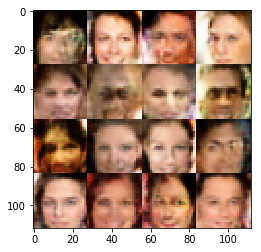

Epoch 1 out of 1
Iteration 1710
Discriminator loss: 1.067539
Generator loss: 2.167097
Epoch 1 out of 1
Iteration 1720
Discriminator loss: 1.016110
Generator loss: 0.877262
Epoch 1 out of 1
Iteration 1730
Discriminator loss: 0.734071
Generator loss: 1.379475
Epoch 1 out of 1
Iteration 1740
Discriminator loss: 1.984552
Generator loss: 0.248974
Epoch 1 out of 1
Iteration 1750
Discriminator loss: 1.040531
Generator loss: 0.833173
Epoch 1 out of 1
Iteration 1760
Discriminator loss: 1.275798
Generator loss: 0.619233
Epoch 1 out of 1
Iteration 1770
Discriminator loss: 1.548479
Generator loss: 0.398423
Epoch 1 out of 1
Iteration 1780
Discriminator loss: 1.213851
Generator loss: 1.323655
Epoch 1 out of 1
Iteration 1790
Discriminator loss: 1.376798
Generator loss: 0.492993
Epoch 1 out of 1
Iteration 1800
Discriminator loss: 1.218914
Generator loss: 0.610993


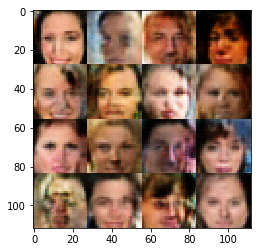

Epoch 1 out of 1
Iteration 1810
Discriminator loss: 1.236846
Generator loss: 0.588988
Epoch 1 out of 1
Iteration 1820
Discriminator loss: 1.362881
Generator loss: 0.552266
Epoch 1 out of 1
Iteration 1830
Discriminator loss: 0.902316
Generator loss: 2.342153
Epoch 1 out of 1
Iteration 1840
Discriminator loss: 0.456085
Generator loss: 3.119187
Epoch 1 out of 1
Iteration 1850
Discriminator loss: 1.213261
Generator loss: 0.651646
Epoch 1 out of 1
Iteration 1860
Discriminator loss: 2.020574
Generator loss: 0.244397
Epoch 1 out of 1
Iteration 1870
Discriminator loss: 0.879727
Generator loss: 1.134910
Epoch 1 out of 1
Iteration 1880
Discriminator loss: 1.328244
Generator loss: 0.543891
Epoch 1 out of 1
Iteration 1890
Discriminator loss: 0.631518
Generator loss: 2.341327
Epoch 1 out of 1
Iteration 1900
Discriminator loss: 2.765803
Generator loss: 0.108798


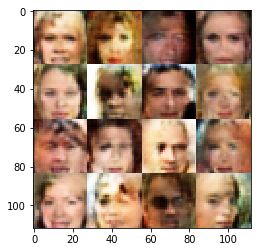

Epoch 1 out of 1
Iteration 1910
Discriminator loss: 0.624196
Generator loss: 3.180770
Epoch 1 out of 1
Iteration 1920
Discriminator loss: 0.457895
Generator loss: 3.319443
Epoch 1 out of 1
Iteration 1930
Discriminator loss: 0.621273
Generator loss: 2.292356
Epoch 1 out of 1
Iteration 1940
Discriminator loss: 0.888784
Generator loss: 1.081478
Epoch 1 out of 1
Iteration 1950
Discriminator loss: 0.969722
Generator loss: 2.428050
Epoch 1 out of 1
Iteration 1960
Discriminator loss: 1.635476
Generator loss: 0.357488
Epoch 1 out of 1
Iteration 1970
Discriminator loss: 0.683628
Generator loss: 2.170187
Epoch 1 out of 1
Iteration 1980
Discriminator loss: 0.778613
Generator loss: 2.188229
Epoch 1 out of 1
Iteration 1990
Discriminator loss: 0.765776
Generator loss: 1.221813
Epoch 1 out of 1
Iteration 2000
Discriminator loss: 1.796270
Generator loss: 0.298924


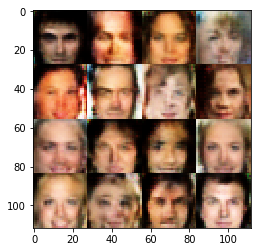

Epoch 1 out of 1
Iteration 2010
Discriminator loss: 0.795351
Generator loss: 1.591959
Epoch 1 out of 1
Iteration 2020
Discriminator loss: 0.946449
Generator loss: 1.237194
Epoch 1 out of 1
Iteration 2030
Discriminator loss: 1.619962
Generator loss: 0.409419
Epoch 1 out of 1
Iteration 2040
Discriminator loss: 1.399655
Generator loss: 0.520510
Epoch 1 out of 1
Iteration 2050
Discriminator loss: 0.644974
Generator loss: 1.683167
Epoch 1 out of 1
Iteration 2060
Discriminator loss: 1.386443
Generator loss: 0.547421
Epoch 1 out of 1
Iteration 2070
Discriminator loss: 1.075533
Generator loss: 0.698919
Epoch 1 out of 1
Iteration 2080
Discriminator loss: 0.803239
Generator loss: 3.699027
Epoch 1 out of 1
Iteration 2090
Discriminator loss: 1.603064
Generator loss: 0.405354
Epoch 1 out of 1
Iteration 2100
Discriminator loss: 1.370968
Generator loss: 0.608936


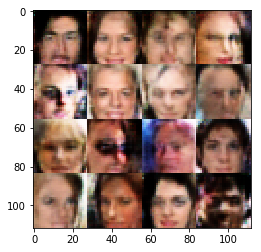

Epoch 1 out of 1
Iteration 2110
Discriminator loss: 0.907099
Generator loss: 0.933712
Epoch 1 out of 1
Iteration 2120
Discriminator loss: 0.887980
Generator loss: 1.168773
Epoch 1 out of 1
Iteration 2130
Discriminator loss: 0.811414
Generator loss: 1.888292
Epoch 1 out of 1
Iteration 2140
Discriminator loss: 0.500515
Generator loss: 2.216551
Epoch 1 out of 1
Iteration 2150
Discriminator loss: 1.121055
Generator loss: 1.229535
Epoch 1 out of 1
Iteration 2160
Discriminator loss: 0.762226
Generator loss: 1.436064
Epoch 1 out of 1
Iteration 2170
Discriminator loss: 0.982618
Generator loss: 0.830576
Epoch 1 out of 1
Iteration 2180
Discriminator loss: 0.770168
Generator loss: 1.552351
Epoch 1 out of 1
Iteration 2190
Discriminator loss: 0.716884
Generator loss: 1.447990
Epoch 1 out of 1
Iteration 2200
Discriminator loss: 1.225848
Generator loss: 1.540322


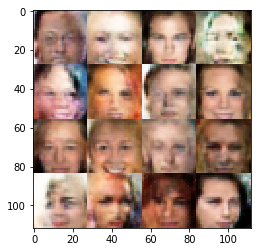

Epoch 1 out of 1
Iteration 2210
Discriminator loss: 1.189088
Generator loss: 0.668500
Epoch 1 out of 1
Iteration 2220
Discriminator loss: 0.610778
Generator loss: 1.646030
Epoch 1 out of 1
Iteration 2230
Discriminator loss: 0.538554
Generator loss: 1.863296
Epoch 1 out of 1
Iteration 2240
Discriminator loss: 1.060139
Generator loss: 1.106634
Epoch 1 out of 1
Iteration 2250
Discriminator loss: 0.388141
Generator loss: 3.811821
Epoch 1 out of 1
Iteration 2260
Discriminator loss: 1.220605
Generator loss: 0.672767
Epoch 1 out of 1
Iteration 2270
Discriminator loss: 1.565514
Generator loss: 0.403055
Epoch 1 out of 1
Iteration 2280
Discriminator loss: 1.471620
Generator loss: 0.659090
Epoch 1 out of 1
Iteration 2290
Discriminator loss: 1.163135
Generator loss: 0.722117
Epoch 1 out of 1
Iteration 2300
Discriminator loss: 1.510404
Generator loss: 0.441092


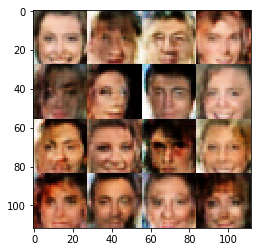

Epoch 1 out of 1
Iteration 2310
Discriminator loss: 0.829929
Generator loss: 1.470339
Epoch 1 out of 1
Iteration 2320
Discriminator loss: 1.113299
Generator loss: 1.436963
Epoch 1 out of 1
Iteration 2330
Discriminator loss: 1.456616
Generator loss: 0.471479
Epoch 1 out of 1
Iteration 2340
Discriminator loss: 1.317503
Generator loss: 0.604359
Epoch 1 out of 1
Iteration 2350
Discriminator loss: 0.878983
Generator loss: 1.146492
Epoch 1 out of 1
Iteration 2360
Discriminator loss: 1.186074
Generator loss: 0.844384
Epoch 1 out of 1
Iteration 2370
Discriminator loss: 0.998486
Generator loss: 2.461546
Epoch 1 out of 1
Iteration 2380
Discriminator loss: 0.786336
Generator loss: 1.912340
Epoch 1 out of 1
Iteration 2390
Discriminator loss: 1.291322
Generator loss: 0.577439
Epoch 1 out of 1
Iteration 2400
Discriminator loss: 1.241025
Generator loss: 0.946084


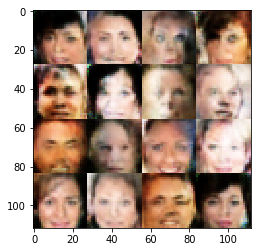

Epoch 1 out of 1
Iteration 2410
Discriminator loss: 2.344743
Generator loss: 0.181295
Epoch 1 out of 1
Iteration 2420
Discriminator loss: 1.032670
Generator loss: 2.535621
Epoch 1 out of 1
Iteration 2430
Discriminator loss: 1.042262
Generator loss: 1.385193
Epoch 1 out of 1
Iteration 2440
Discriminator loss: 1.485492
Generator loss: 0.478878
Epoch 1 out of 1
Iteration 2450
Discriminator loss: 1.317802
Generator loss: 1.632218
Epoch 1 out of 1
Iteration 2460
Discriminator loss: 0.770118
Generator loss: 2.531605
Epoch 1 out of 1
Iteration 2470
Discriminator loss: 1.048360
Generator loss: 0.872708
Epoch 1 out of 1
Iteration 2480
Discriminator loss: 1.995728
Generator loss: 0.245090
Epoch 1 out of 1
Iteration 2490
Discriminator loss: 0.685664
Generator loss: 1.613636
Epoch 1 out of 1
Iteration 2500
Discriminator loss: 0.730429
Generator loss: 2.198102


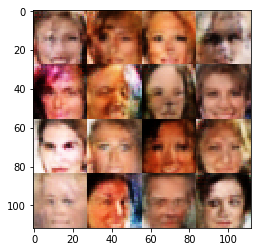

Epoch 1 out of 1
Iteration 2510
Discriminator loss: 0.953288
Generator loss: 0.936136
Epoch 1 out of 1
Iteration 2520
Discriminator loss: 0.646170
Generator loss: 2.496600
Epoch 1 out of 1
Iteration 2530
Discriminator loss: 0.713696
Generator loss: 1.369101
Epoch 1 out of 1
Iteration 2540
Discriminator loss: 0.821220
Generator loss: 1.231929
Epoch 1 out of 1
Iteration 2550
Discriminator loss: 1.009208
Generator loss: 1.111543
Epoch 1 out of 1
Iteration 2560
Discriminator loss: 0.853132
Generator loss: 1.460807
Epoch 1 out of 1
Iteration 2570
Discriminator loss: 0.623568
Generator loss: 1.918658
Epoch 1 out of 1
Iteration 2580
Discriminator loss: 1.070789
Generator loss: 0.749375
Epoch 1 out of 1
Iteration 2590
Discriminator loss: 1.346538
Generator loss: 0.557783
Epoch 1 out of 1
Iteration 2600
Discriminator loss: 0.751467
Generator loss: 1.287571


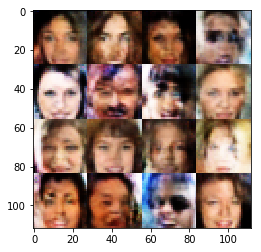

Epoch 1 out of 1
Iteration 2610
Discriminator loss: 1.778003
Generator loss: 0.330368
Epoch 1 out of 1
Iteration 2620
Discriminator loss: 0.804434
Generator loss: 1.607973
Epoch 1 out of 1
Iteration 2630
Discriminator loss: 1.103906
Generator loss: 1.068530
Epoch 1 out of 1
Iteration 2640
Discriminator loss: 0.891636
Generator loss: 1.130196
Epoch 1 out of 1
Iteration 2650
Discriminator loss: 0.880665
Generator loss: 2.009279
Epoch 1 out of 1
Iteration 2660
Discriminator loss: 1.114234
Generator loss: 0.825882
Epoch 1 out of 1
Iteration 2670
Discriminator loss: 0.835034
Generator loss: 1.593427
Epoch 1 out of 1
Iteration 2680
Discriminator loss: 0.654177
Generator loss: 2.463157
Epoch 1 out of 1
Iteration 2690
Discriminator loss: 0.651529
Generator loss: 1.533042
Epoch 1 out of 1
Iteration 2700
Discriminator loss: 1.477156
Generator loss: 0.594809


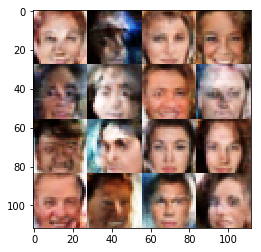

Epoch 1 out of 1
Iteration 2710
Discriminator loss: 0.866669
Generator loss: 1.084291
Epoch 1 out of 1
Iteration 2720
Discriminator loss: 1.172170
Generator loss: 1.359137
Epoch 1 out of 1
Iteration 2730
Discriminator loss: 0.684263
Generator loss: 2.542347
Epoch 1 out of 1
Iteration 2740
Discriminator loss: 1.130474
Generator loss: 0.843860
Epoch 1 out of 1
Iteration 2750
Discriminator loss: 2.025527
Generator loss: 0.240431
Epoch 1 out of 1
Iteration 2760
Discriminator loss: 1.108597
Generator loss: 0.780278
Epoch 1 out of 1
Iteration 2770
Discriminator loss: 0.592776
Generator loss: 2.417219
Epoch 1 out of 1
Iteration 2780
Discriminator loss: 1.393415
Generator loss: 0.518774
Epoch 1 out of 1
Iteration 2790
Discriminator loss: 0.866449
Generator loss: 1.687946
Epoch 1 out of 1
Iteration 2800
Discriminator loss: 1.070612
Generator loss: 1.981396


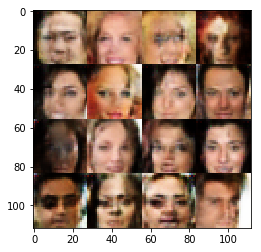

Epoch 1 out of 1
Iteration 2810
Discriminator loss: 1.326825
Generator loss: 0.864251
Epoch 1 out of 1
Iteration 2820
Discriminator loss: 0.695950
Generator loss: 2.016321
Epoch 1 out of 1
Iteration 2830
Discriminator loss: 1.333422
Generator loss: 0.631610
Epoch 1 out of 1
Iteration 2840
Discriminator loss: 1.333442
Generator loss: 0.605253
Epoch 1 out of 1
Iteration 2850
Discriminator loss: 1.348720
Generator loss: 0.521283
Epoch 1 out of 1
Iteration 2860
Discriminator loss: 0.860687
Generator loss: 1.092086
Epoch 1 out of 1
Iteration 2870
Discriminator loss: 0.888648
Generator loss: 2.264448
Epoch 1 out of 1
Iteration 2880
Discriminator loss: 1.360068
Generator loss: 0.529221
Epoch 1 out of 1
Iteration 2890
Discriminator loss: 1.095836
Generator loss: 0.892909
Epoch 1 out of 1
Iteration 2900
Discriminator loss: 0.836939
Generator loss: 1.341700


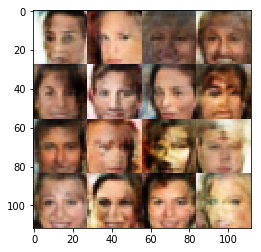

Epoch 1 out of 1
Iteration 2910
Discriminator loss: 0.891330
Generator loss: 3.408826
Epoch 1 out of 1
Iteration 2920
Discriminator loss: 0.739447
Generator loss: 1.479040
Epoch 1 out of 1
Iteration 2930
Discriminator loss: 0.948451
Generator loss: 1.068024
Epoch 1 out of 1
Iteration 2940
Discriminator loss: 1.454786
Generator loss: 0.463323
Epoch 1 out of 1
Iteration 2950
Discriminator loss: 1.325428
Generator loss: 0.555763
Epoch 1 out of 1
Iteration 2960
Discriminator loss: 0.826362
Generator loss: 1.447702
Epoch 1 out of 1
Iteration 2970
Discriminator loss: 0.836976
Generator loss: 1.427057
Epoch 1 out of 1
Iteration 2980
Discriminator loss: 0.772480
Generator loss: 2.212893
Epoch 1 out of 1
Iteration 2990
Discriminator loss: 1.882317
Generator loss: 0.316263
Epoch 1 out of 1
Iteration 3000
Discriminator loss: 1.339538
Generator loss: 0.578636


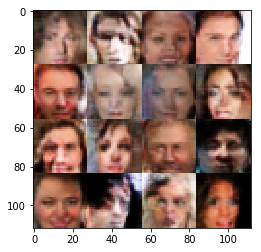

Epoch 1 out of 1
Iteration 3010
Discriminator loss: 1.327634
Generator loss: 0.955623
Epoch 1 out of 1
Iteration 3020
Discriminator loss: 1.377020
Generator loss: 0.552877
Epoch 1 out of 1
Iteration 3030
Discriminator loss: 0.816922
Generator loss: 1.470220
Epoch 1 out of 1
Iteration 3040
Discriminator loss: 1.214039
Generator loss: 0.669975
Epoch 1 out of 1
Iteration 3050
Discriminator loss: 0.977728
Generator loss: 1.509303
Epoch 1 out of 1
Iteration 3060
Discriminator loss: 1.483337
Generator loss: 0.460561
Epoch 1 out of 1
Iteration 3070
Discriminator loss: 1.750987
Generator loss: 0.397573
Epoch 1 out of 1
Iteration 3080
Discriminator loss: 1.558192
Generator loss: 0.391983
Epoch 1 out of 1
Iteration 3090
Discriminator loss: 0.974444
Generator loss: 1.114921
Epoch 1 out of 1
Iteration 3100
Discriminator loss: 1.625235
Generator loss: 0.429958


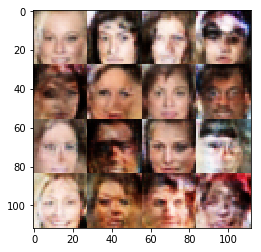

Epoch 1 out of 1
Iteration 3110
Discriminator loss: 1.168385
Generator loss: 0.689733
Epoch 1 out of 1
Iteration 3120
Discriminator loss: 0.922198
Generator loss: 1.055995
Epoch 1 out of 1
Iteration 3130
Discriminator loss: 1.295012
Generator loss: 0.574040
Epoch 1 out of 1
Iteration 3140
Discriminator loss: 0.848687
Generator loss: 1.198644
Epoch 1 out of 1
Iteration 3150
Discriminator loss: 1.084963
Generator loss: 2.089177
Epoch 1 out of 1
Iteration 3160
Discriminator loss: 1.287107
Generator loss: 0.861526
Epoch 1 out of 1
Iteration 3170
Discriminator loss: 0.858177
Generator loss: 1.210465
Epoch 1 out of 1
Iteration 3180
Discriminator loss: 1.072590
Generator loss: 0.869219
Epoch 1 out of 1
Iteration 3190
Discriminator loss: 1.618493
Generator loss: 0.388761
Epoch 1 out of 1
Iteration 3200
Discriminator loss: 2.025095
Generator loss: 0.234490


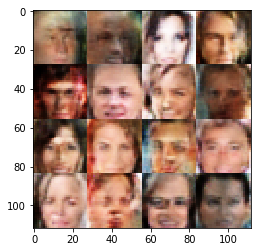

Epoch 1 out of 1
Iteration 3210
Discriminator loss: 1.266753
Generator loss: 0.707148
Epoch 1 out of 1
Iteration 3220
Discriminator loss: 0.914710
Generator loss: 1.282067
Epoch 1 out of 1
Iteration 3230
Discriminator loss: 1.116236
Generator loss: 0.760661
Epoch 1 out of 1
Iteration 3240
Discriminator loss: 1.449063
Generator loss: 0.568416
Epoch 1 out of 1
Iteration 3250
Discriminator loss: 1.326316
Generator loss: 0.715101
Epoch 1 out of 1
Iteration 3260
Discriminator loss: 0.928517
Generator loss: 1.092808
Epoch 1 out of 1
Iteration 3270
Discriminator loss: 0.981920
Generator loss: 1.033059
Epoch 1 out of 1
Iteration 3280
Discriminator loss: 0.550223
Generator loss: 2.034760
Epoch 1 out of 1
Iteration 3290
Discriminator loss: 0.711957
Generator loss: 2.718818
Epoch 1 out of 1
Iteration 3300
Discriminator loss: 1.465650
Generator loss: 0.461049


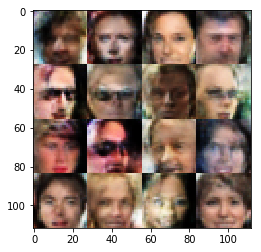

Epoch 1 out of 1
Iteration 3310
Discriminator loss: 1.052224
Generator loss: 0.991202
Epoch 1 out of 1
Iteration 3320
Discriminator loss: 0.838812
Generator loss: 1.105639
Epoch 1 out of 1
Iteration 3330
Discriminator loss: 0.969884
Generator loss: 1.425332
Epoch 1 out of 1
Iteration 3340
Discriminator loss: 1.137170
Generator loss: 0.677023
Epoch 1 out of 1
Iteration 3350
Discriminator loss: 1.545609
Generator loss: 0.444143
Epoch 1 out of 1
Iteration 3360
Discriminator loss: 1.403676
Generator loss: 0.511877
Epoch 1 out of 1
Iteration 3370
Discriminator loss: 0.788990
Generator loss: 1.736200
Epoch 1 out of 1
Iteration 3380
Discriminator loss: 1.158241
Generator loss: 0.901930
Epoch 1 out of 1
Iteration 3390
Discriminator loss: 1.208755
Generator loss: 0.765010
Epoch 1 out of 1
Iteration 3400
Discriminator loss: 1.085099
Generator loss: 0.800215


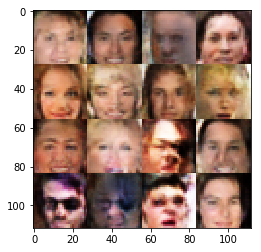

Epoch 1 out of 1
Iteration 3410
Discriminator loss: 1.190612
Generator loss: 0.895494
Epoch 1 out of 1
Iteration 3420
Discriminator loss: 1.464297
Generator loss: 0.454605
Epoch 1 out of 1
Iteration 3430
Discriminator loss: 1.353137
Generator loss: 0.521081
Epoch 1 out of 1
Iteration 3440
Discriminator loss: 1.036273
Generator loss: 1.162946
Epoch 1 out of 1
Iteration 3450
Discriminator loss: 1.419427
Generator loss: 0.554869
Epoch 1 out of 1
Iteration 3460
Discriminator loss: 1.105955
Generator loss: 1.014806
Epoch 1 out of 1
Iteration 3470
Discriminator loss: 0.838616
Generator loss: 1.137719
Epoch 1 out of 1
Iteration 3480
Discriminator loss: 1.714237
Generator loss: 1.263464
Epoch 1 out of 1
Iteration 3490
Discriminator loss: 0.840244
Generator loss: 1.356763
Epoch 1 out of 1
Iteration 3500
Discriminator loss: 1.276390
Generator loss: 0.634105


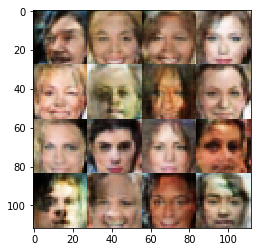

Epoch 1 out of 1
Iteration 3510
Discriminator loss: 1.339916
Generator loss: 0.569592
Epoch 1 out of 1
Iteration 3520
Discriminator loss: 1.566278
Generator loss: 0.444318
Epoch 1 out of 1
Iteration 3530
Discriminator loss: 1.703578
Generator loss: 0.359677
Epoch 1 out of 1
Iteration 3540
Discriminator loss: 1.610600
Generator loss: 0.568536
Epoch 1 out of 1
Iteration 3550
Discriminator loss: 1.386774
Generator loss: 0.617552
Epoch 1 out of 1
Iteration 3560
Discriminator loss: 0.878191
Generator loss: 2.274899
Epoch 1 out of 1
Iteration 3570
Discriminator loss: 1.171438
Generator loss: 0.821764
Epoch 1 out of 1
Iteration 3580
Discriminator loss: 0.797152
Generator loss: 1.616295
Epoch 1 out of 1
Iteration 3590
Discriminator loss: 1.259316
Generator loss: 1.311764
Epoch 1 out of 1
Iteration 3600
Discriminator loss: 1.472491
Generator loss: 0.840164


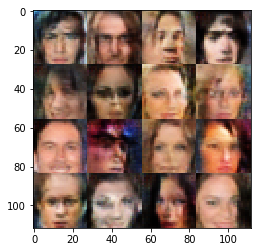

Epoch 1 out of 1
Iteration 3610
Discriminator loss: 1.098593
Generator loss: 1.150687
Epoch 1 out of 1
Iteration 3620
Discriminator loss: 1.066497
Generator loss: 0.802684
Epoch 1 out of 1
Iteration 3630
Discriminator loss: 1.390161
Generator loss: 0.593178
Epoch 1 out of 1
Iteration 3640
Discriminator loss: 1.260956
Generator loss: 0.729190
Epoch 1 out of 1
Iteration 3650
Discriminator loss: 0.681390
Generator loss: 2.134795
Epoch 1 out of 1
Iteration 3660
Discriminator loss: 1.058209
Generator loss: 1.229002
Epoch 1 out of 1
Iteration 3670
Discriminator loss: 0.978457
Generator loss: 1.117627
Epoch 1 out of 1
Iteration 3680
Discriminator loss: 0.939838
Generator loss: 1.427837
Epoch 1 out of 1
Iteration 3690
Discriminator loss: 1.308922
Generator loss: 0.579747
Epoch 1 out of 1
Iteration 3700
Discriminator loss: 1.130865
Generator loss: 0.794204


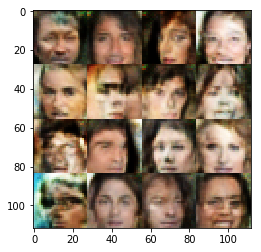

Epoch 1 out of 1
Iteration 3710
Discriminator loss: 0.927802
Generator loss: 1.481826
Epoch 1 out of 1
Iteration 3720
Discriminator loss: 1.367091
Generator loss: 0.646081
Epoch 1 out of 1
Iteration 3730
Discriminator loss: 1.278008
Generator loss: 0.631644
Epoch 1 out of 1
Iteration 3740
Discriminator loss: 1.336217
Generator loss: 0.550869
Epoch 1 out of 1
Iteration 3750
Discriminator loss: 1.678926
Generator loss: 0.375184
Epoch 1 out of 1
Iteration 3760
Discriminator loss: 1.119079
Generator loss: 0.799628
Epoch 1 out of 1
Iteration 3770
Discriminator loss: 1.280576
Generator loss: 0.734984
Epoch 1 out of 1
Iteration 3780
Discriminator loss: 1.139456
Generator loss: 0.694444
Epoch 1 out of 1
Iteration 3790
Discriminator loss: 1.095945
Generator loss: 1.080739
Epoch 1 out of 1
Iteration 3800
Discriminator loss: 1.230117
Generator loss: 0.727188


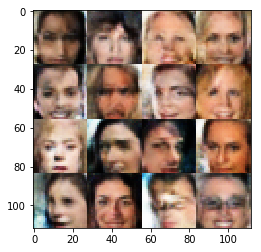

Epoch 1 out of 1
Iteration 3810
Discriminator loss: 1.272386
Generator loss: 0.627298
Epoch 1 out of 1
Iteration 3820
Discriminator loss: 1.089679
Generator loss: 1.207983
Epoch 1 out of 1
Iteration 3830
Discriminator loss: 1.875438
Generator loss: 0.311429
Epoch 1 out of 1
Iteration 3840
Discriminator loss: 1.522350
Generator loss: 0.529727
Epoch 1 out of 1
Iteration 3850
Discriminator loss: 1.624348
Generator loss: 0.490205
Epoch 1 out of 1
Iteration 3860
Discriminator loss: 1.213734
Generator loss: 0.764344
Epoch 1 out of 1
Iteration 3870
Discriminator loss: 0.961911
Generator loss: 1.024471
Epoch 1 out of 1
Iteration 3880
Discriminator loss: 1.139441
Generator loss: 1.336762
Epoch 1 out of 1
Iteration 3890
Discriminator loss: 1.423549
Generator loss: 0.524432
Epoch 1 out of 1
Iteration 3900
Discriminator loss: 1.198473
Generator loss: 0.755432


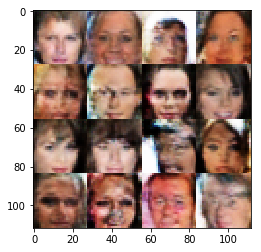

Epoch 1 out of 1
Iteration 3910
Discriminator loss: 1.470076
Generator loss: 0.551576
Epoch 1 out of 1
Iteration 3920
Discriminator loss: 1.199552
Generator loss: 0.833495
Epoch 1 out of 1
Iteration 3930
Discriminator loss: 0.936136
Generator loss: 1.166543
Epoch 1 out of 1
Iteration 3940
Discriminator loss: 0.985868
Generator loss: 1.229933
Epoch 1 out of 1
Iteration 3950
Discriminator loss: 0.975290
Generator loss: 1.005524
Epoch 1 out of 1
Iteration 3960
Discriminator loss: 1.079247
Generator loss: 0.947627
Epoch 1 out of 1
Iteration 3970
Discriminator loss: 1.043691
Generator loss: 0.945704
Epoch 1 out of 1
Iteration 3980
Discriminator loss: 1.542832
Generator loss: 0.448992
Epoch 1 out of 1
Iteration 3990
Discriminator loss: 1.510432
Generator loss: 0.487952
Epoch 1 out of 1
Iteration 4000
Discriminator loss: 1.499580
Generator loss: 0.519971


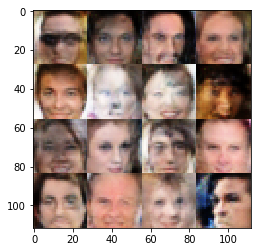

Epoch 1 out of 1
Iteration 4010
Discriminator loss: 1.126619
Generator loss: 0.833315
Epoch 1 out of 1
Iteration 4020
Discriminator loss: 1.411680
Generator loss: 0.536150
Epoch 1 out of 1
Iteration 4030
Discriminator loss: 1.231231
Generator loss: 0.724354
Epoch 1 out of 1
Iteration 4040
Discriminator loss: 1.276494
Generator loss: 0.620077
Epoch 1 out of 1
Iteration 4050
Discriminator loss: 0.987015
Generator loss: 1.067664
Epoch 1 out of 1
Iteration 4060
Discriminator loss: 0.767491
Generator loss: 1.850105
Epoch 1 out of 1
Iteration 4070
Discriminator loss: 1.216822
Generator loss: 0.773516
Epoch 1 out of 1
Iteration 4080
Discriminator loss: 1.372189
Generator loss: 0.680738
Epoch 1 out of 1
Iteration 4090
Discriminator loss: 1.047445
Generator loss: 0.865698
Epoch 1 out of 1
Iteration 4100
Discriminator loss: 0.651674
Generator loss: 2.444908


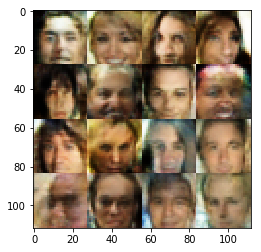

Epoch 1 out of 1
Iteration 4110
Discriminator loss: 1.368447
Generator loss: 0.669198
Epoch 1 out of 1
Iteration 4120
Discriminator loss: 0.790162
Generator loss: 1.574084
Epoch 1 out of 1
Iteration 4130
Discriminator loss: 1.473446
Generator loss: 0.811457
Epoch 1 out of 1
Iteration 4140
Discriminator loss: 0.736892
Generator loss: 2.240633
Epoch 1 out of 1
Iteration 4150
Discriminator loss: 1.080815
Generator loss: 0.801887
Epoch 1 out of 1
Iteration 4160
Discriminator loss: 0.763114
Generator loss: 2.253479
Epoch 1 out of 1
Iteration 4170
Discriminator loss: 1.059241
Generator loss: 0.805217
Epoch 1 out of 1
Iteration 4180
Discriminator loss: 1.097593
Generator loss: 0.919562
Epoch 1 out of 1
Iteration 4190
Discriminator loss: 2.031666
Generator loss: 0.280584
Epoch 1 out of 1
Iteration 4200
Discriminator loss: 1.275702
Generator loss: 0.647769


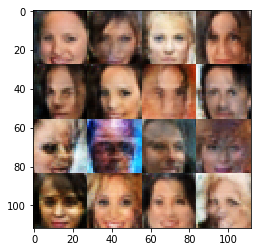

Epoch 1 out of 1
Iteration 4210
Discriminator loss: 1.418918
Generator loss: 0.692504
Epoch 1 out of 1
Iteration 4220
Discriminator loss: 1.067249
Generator loss: 1.981938
Epoch 1 out of 1
Iteration 4230
Discriminator loss: 0.906599
Generator loss: 0.959790
Epoch 1 out of 1
Iteration 4240
Discriminator loss: 1.242242
Generator loss: 0.824000
Epoch 1 out of 1
Iteration 4250
Discriminator loss: 1.084075
Generator loss: 0.904062
Epoch 1 out of 1
Iteration 4260
Discriminator loss: 1.035481
Generator loss: 0.955414
Epoch 1 out of 1
Iteration 4270
Discriminator loss: 1.260891
Generator loss: 0.682767
Epoch 1 out of 1
Iteration 4280
Discriminator loss: 1.325710
Generator loss: 0.592934
Epoch 1 out of 1
Iteration 4290
Discriminator loss: 0.694153
Generator loss: 1.969434
Epoch 1 out of 1
Iteration 4300
Discriminator loss: 0.995227
Generator loss: 1.087027


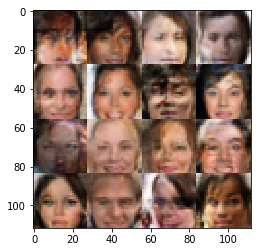

Epoch 1 out of 1
Iteration 4310
Discriminator loss: 1.221850
Generator loss: 0.696847
Epoch 1 out of 1
Iteration 4320
Discriminator loss: 1.445161
Generator loss: 0.510839
Epoch 1 out of 1
Iteration 4330
Discriminator loss: 1.503222
Generator loss: 0.469948
Epoch 1 out of 1
Iteration 4340
Discriminator loss: 1.399531
Generator loss: 0.539026
Epoch 1 out of 1
Iteration 4350
Discriminator loss: 1.296356
Generator loss: 0.793836
Epoch 1 out of 1
Iteration 4360
Discriminator loss: 1.234578
Generator loss: 0.818462
Epoch 1 out of 1
Iteration 4370
Discriminator loss: 1.057265
Generator loss: 1.144354
Epoch 1 out of 1
Iteration 4380
Discriminator loss: 0.777391
Generator loss: 1.412241
Epoch 1 out of 1
Iteration 4390
Discriminator loss: 1.646151
Generator loss: 0.378334
Epoch 1 out of 1
Iteration 4400
Discriminator loss: 1.202635
Generator loss: 0.620749


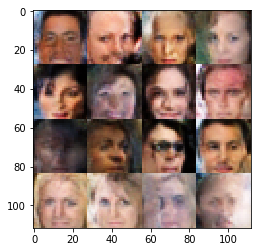

Epoch 1 out of 1
Iteration 4410
Discriminator loss: 1.160462
Generator loss: 0.789054
Epoch 1 out of 1
Iteration 4420
Discriminator loss: 1.304034
Generator loss: 0.636539
Epoch 1 out of 1
Iteration 4430
Discriminator loss: 1.171733
Generator loss: 0.686179
Epoch 1 out of 1
Iteration 4440
Discriminator loss: 1.004320
Generator loss: 1.008644
Epoch 1 out of 1
Iteration 4450
Discriminator loss: 0.938926
Generator loss: 1.154611
Epoch 1 out of 1
Iteration 4460
Discriminator loss: 0.725252
Generator loss: 1.479921
Epoch 1 out of 1
Iteration 4470
Discriminator loss: 1.188507
Generator loss: 0.958668
Epoch 1 out of 1
Iteration 4480
Discriminator loss: 0.844811
Generator loss: 1.393249
Epoch 1 out of 1
Iteration 4490
Discriminator loss: 1.420356
Generator loss: 0.604411
Epoch 1 out of 1
Iteration 4500
Discriminator loss: 1.228870
Generator loss: 0.727120


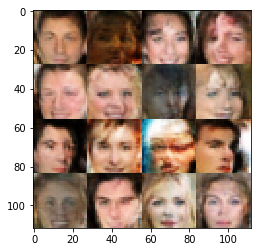

Epoch 1 out of 1
Iteration 4510
Discriminator loss: 1.149805
Generator loss: 0.762317
Epoch 1 out of 1
Iteration 4520
Discriminator loss: 1.273344
Generator loss: 0.637461
Epoch 1 out of 1
Iteration 4530
Discriminator loss: 1.204449
Generator loss: 0.740153
Epoch 1 out of 1
Iteration 4540
Discriminator loss: 1.069050
Generator loss: 0.884810
Epoch 1 out of 1
Iteration 4550
Discriminator loss: 0.720534
Generator loss: 1.440728
Epoch 1 out of 1
Iteration 4560
Discriminator loss: 1.407796
Generator loss: 0.877018
Epoch 1 out of 1
Iteration 4570
Discriminator loss: 1.538103
Generator loss: 0.421876
Epoch 1 out of 1
Iteration 4580
Discriminator loss: 0.747292
Generator loss: 1.604206
Epoch 1 out of 1
Iteration 4590
Discriminator loss: 0.970409
Generator loss: 0.988838
Epoch 1 out of 1
Iteration 4600
Discriminator loss: 1.055768
Generator loss: 0.979692


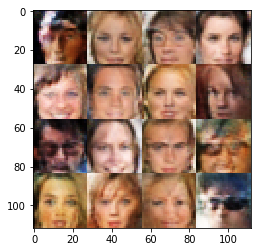

Epoch 1 out of 1
Iteration 4610
Discriminator loss: 0.921883
Generator loss: 1.218830
Epoch 1 out of 1
Iteration 4620
Discriminator loss: 1.119241
Generator loss: 0.740130
Epoch 1 out of 1
Iteration 4630
Discriminator loss: 1.590403
Generator loss: 0.394388
Epoch 1 out of 1
Iteration 4640
Discriminator loss: 1.539512
Generator loss: 0.436174
Epoch 1 out of 1
Iteration 4650
Discriminator loss: 1.495523
Generator loss: 0.482639
Epoch 1 out of 1
Iteration 4660
Discriminator loss: 1.510167
Generator loss: 0.434291
Epoch 1 out of 1
Iteration 4670
Discriminator loss: 0.793330
Generator loss: 1.629549
Epoch 1 out of 1
Iteration 4680
Discriminator loss: 1.041768
Generator loss: 1.101968
Epoch 1 out of 1
Iteration 4690
Discriminator loss: 1.515490
Generator loss: 0.479184
Epoch 1 out of 1
Iteration 4700
Discriminator loss: 1.297388
Generator loss: 0.653721


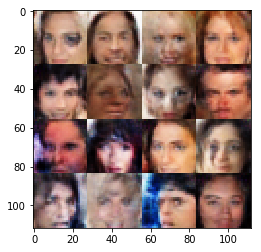

Epoch 1 out of 1
Iteration 4710
Discriminator loss: 1.281610
Generator loss: 0.718458
Epoch 1 out of 1
Iteration 4720
Discriminator loss: 1.116582
Generator loss: 0.791684
Epoch 1 out of 1
Iteration 4730
Discriminator loss: 1.387748
Generator loss: 0.546422
Epoch 1 out of 1
Iteration 4740
Discriminator loss: 1.030280
Generator loss: 0.891068
Epoch 1 out of 1
Iteration 4750
Discriminator loss: 1.547795
Generator loss: 0.418356
Epoch 1 out of 1
Iteration 4760
Discriminator loss: 1.294658
Generator loss: 0.637312
Epoch 1 out of 1
Iteration 4770
Discriminator loss: 1.532130
Generator loss: 0.536800
Epoch 1 out of 1
Iteration 4780
Discriminator loss: 1.663078
Generator loss: 0.383423
Epoch 1 out of 1
Iteration 4790
Discriminator loss: 1.244977
Generator loss: 0.701669
Epoch 1 out of 1
Iteration 4800
Discriminator loss: 1.122488
Generator loss: 0.841159


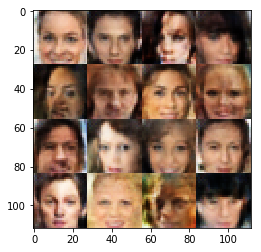

Epoch 1 out of 1
Iteration 4810
Discriminator loss: 1.094927
Generator loss: 0.851631
Epoch 1 out of 1
Iteration 4820
Discriminator loss: 1.071899
Generator loss: 1.505388
Epoch 1 out of 1
Iteration 4830
Discriminator loss: 0.843431
Generator loss: 1.196144
Epoch 1 out of 1
Iteration 4840
Discriminator loss: 1.061904
Generator loss: 1.038040
Epoch 1 out of 1
Iteration 4850
Discriminator loss: 1.559159
Generator loss: 0.505126
Epoch 1 out of 1
Iteration 4860
Discriminator loss: 1.338018
Generator loss: 0.600458
Epoch 1 out of 1
Iteration 4870
Discriminator loss: 1.228907
Generator loss: 0.775159
Epoch 1 out of 1
Iteration 4880
Discriminator loss: 1.038544
Generator loss: 1.002353
Epoch 1 out of 1
Iteration 4890
Discriminator loss: 0.672434
Generator loss: 2.073568
Epoch 1 out of 1
Iteration 4900
Discriminator loss: 0.937641
Generator loss: 1.124220


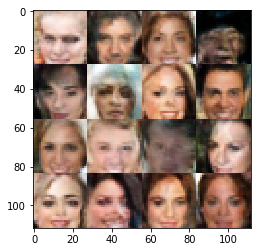

Epoch 1 out of 1
Iteration 4910
Discriminator loss: 1.124849
Generator loss: 0.730252
Epoch 1 out of 1
Iteration 4920
Discriminator loss: 1.369472
Generator loss: 0.564615
Epoch 1 out of 1
Iteration 4930
Discriminator loss: 1.367330
Generator loss: 0.583898
Epoch 1 out of 1
Iteration 4940
Discriminator loss: 1.079560
Generator loss: 0.854875
Epoch 1 out of 1
Iteration 4950
Discriminator loss: 0.902844
Generator loss: 1.093004
Epoch 1 out of 1
Iteration 4960
Discriminator loss: 1.073164
Generator loss: 1.272130
Epoch 1 out of 1
Iteration 4970
Discriminator loss: 1.253227
Generator loss: 0.772195
Epoch 1 out of 1
Iteration 4980
Discriminator loss: 1.503930
Generator loss: 0.408739
Epoch 1 out of 1
Iteration 4990
Discriminator loss: 1.235272
Generator loss: 0.715481
Epoch 1 out of 1
Iteration 5000
Discriminator loss: 1.317949
Generator loss: 0.644794


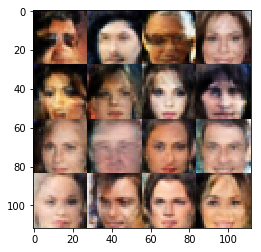

Epoch 1 out of 1
Iteration 5010
Discriminator loss: 1.657644
Generator loss: 0.401500
Epoch 1 out of 1
Iteration 5020
Discriminator loss: 1.272664
Generator loss: 0.723536
Epoch 1 out of 1
Iteration 5030
Discriminator loss: 1.158086
Generator loss: 0.945641
Epoch 1 out of 1
Iteration 5040
Discriminator loss: 1.340300
Generator loss: 0.652887
Epoch 1 out of 1
Iteration 5050
Discriminator loss: 1.064925
Generator loss: 1.523058
Epoch 1 out of 1
Iteration 5060
Discriminator loss: 1.200751
Generator loss: 0.753723
Epoch 1 out of 1
Iteration 5070
Discriminator loss: 1.308339
Generator loss: 0.613571
Epoch 1 out of 1
Iteration 5080
Discriminator loss: 1.375861
Generator loss: 0.622725
Epoch 1 out of 1
Iteration 5090
Discriminator loss: 0.940472
Generator loss: 1.166047
Epoch 1 out of 1
Iteration 5100
Discriminator loss: 1.768898
Generator loss: 0.332029


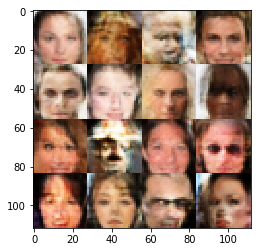

Epoch 1 out of 1
Iteration 5110
Discriminator loss: 1.547698
Generator loss: 0.528042
Epoch 1 out of 1
Iteration 5120
Discriminator loss: 1.058760
Generator loss: 2.433580
Epoch 1 out of 1
Iteration 5130
Discriminator loss: 1.516328
Generator loss: 0.521331
Epoch 1 out of 1
Iteration 5140
Discriminator loss: 1.019326
Generator loss: 1.029936
Epoch 1 out of 1
Iteration 5150
Discriminator loss: 1.198506
Generator loss: 0.821450
Epoch 1 out of 1
Iteration 5160
Discriminator loss: 1.429779
Generator loss: 0.507175
Epoch 1 out of 1
Iteration 5170
Discriminator loss: 1.527104
Generator loss: 0.499810
Epoch 1 out of 1
Iteration 5180
Discriminator loss: 1.220140
Generator loss: 0.724967
Epoch 1 out of 1
Iteration 5190
Discriminator loss: 2.183288
Generator loss: 0.208372
Epoch 1 out of 1
Iteration 5200
Discriminator loss: 1.250660
Generator loss: 0.729857


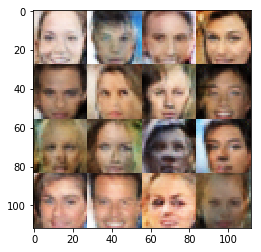

Epoch 1 out of 1
Iteration 5210
Discriminator loss: 1.155612
Generator loss: 0.816577
Epoch 1 out of 1
Iteration 5220
Discriminator loss: 1.187008
Generator loss: 0.972681
Epoch 1 out of 1
Iteration 5230
Discriminator loss: 1.452003
Generator loss: 0.555670
Epoch 1 out of 1
Iteration 5240
Discriminator loss: 1.617298
Generator loss: 0.385938
Epoch 1 out of 1
Iteration 5250
Discriminator loss: 1.056287
Generator loss: 0.984189
Epoch 1 out of 1
Iteration 5260
Discriminator loss: 1.198622
Generator loss: 0.693536
Epoch 1 out of 1
Iteration 5270
Discriminator loss: 1.185377
Generator loss: 0.712130
Epoch 1 out of 1
Iteration 5280
Discriminator loss: 0.962097
Generator loss: 1.065508
Epoch 1 out of 1
Iteration 5290
Discriminator loss: 1.257860
Generator loss: 0.692920
Epoch 1 out of 1
Iteration 5300
Discriminator loss: 0.799815
Generator loss: 1.371227


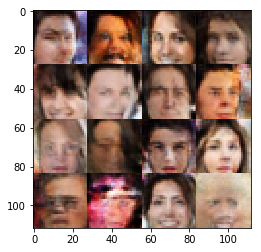

Epoch 1 out of 1
Iteration 5310
Discriminator loss: 1.310873
Generator loss: 0.693908
Epoch 1 out of 1
Iteration 5320
Discriminator loss: 1.006911
Generator loss: 0.899730
Epoch 1 out of 1
Iteration 5330
Discriminator loss: 1.210136
Generator loss: 0.875590
Epoch 1 out of 1
Iteration 5340
Discriminator loss: 0.999740
Generator loss: 1.449913
Epoch 1 out of 1
Iteration 5350
Discriminator loss: 0.834588
Generator loss: 1.644547
Epoch 1 out of 1
Iteration 5360
Discriminator loss: 1.223401
Generator loss: 0.744474
Epoch 1 out of 1
Iteration 5370
Discriminator loss: 1.226337
Generator loss: 0.863720
Epoch 1 out of 1
Iteration 5380
Discriminator loss: 1.378828
Generator loss: 0.595599
Epoch 1 out of 1
Iteration 5390
Discriminator loss: 1.434493
Generator loss: 0.563024
Epoch 1 out of 1
Iteration 5400
Discriminator loss: 1.007882
Generator loss: 1.014948


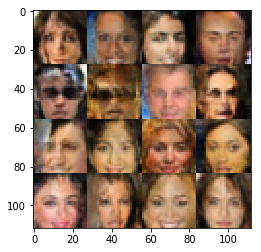

Epoch 1 out of 1
Iteration 5410
Discriminator loss: 1.262788
Generator loss: 0.656258
Epoch 1 out of 1
Iteration 5420
Discriminator loss: 1.304277
Generator loss: 0.978378
Epoch 1 out of 1
Iteration 5430
Discriminator loss: 0.928330
Generator loss: 0.959031
Epoch 1 out of 1
Iteration 5440
Discriminator loss: 1.099286
Generator loss: 0.868918
Epoch 1 out of 1
Iteration 5450
Discriminator loss: 1.149912
Generator loss: 0.781673
Epoch 1 out of 1
Iteration 5460
Discriminator loss: 1.142452
Generator loss: 0.778011
Epoch 1 out of 1
Iteration 5470
Discriminator loss: 0.932150
Generator loss: 1.297690
Epoch 1 out of 1
Iteration 5480
Discriminator loss: 1.098488
Generator loss: 1.096354
Epoch 1 out of 1
Iteration 5490
Discriminator loss: 1.447725
Generator loss: 0.470866
Epoch 1 out of 1
Iteration 5500
Discriminator loss: 1.760060
Generator loss: 0.329738


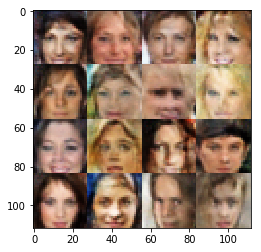

Epoch 1 out of 1
Iteration 5510
Discriminator loss: 1.395306
Generator loss: 0.575461
Epoch 1 out of 1
Iteration 5520
Discriminator loss: 1.478388
Generator loss: 0.482441
Epoch 1 out of 1
Iteration 5530
Discriminator loss: 1.288844
Generator loss: 0.756687
Epoch 1 out of 1
Iteration 5540
Discriminator loss: 1.737742
Generator loss: 0.397172
Epoch 1 out of 1
Iteration 5550
Discriminator loss: 1.417283
Generator loss: 0.523048
Epoch 1 out of 1
Iteration 5560
Discriminator loss: 1.469157
Generator loss: 0.558124
Epoch 1 out of 1
Iteration 5570
Discriminator loss: 1.600873
Generator loss: 0.445190
Epoch 1 out of 1
Iteration 5580
Discriminator loss: 1.202885
Generator loss: 0.732510
Epoch 1 out of 1
Iteration 5590
Discriminator loss: 1.862231
Generator loss: 0.335085
Epoch 1 out of 1
Iteration 5600
Discriminator loss: 1.299349
Generator loss: 0.949058


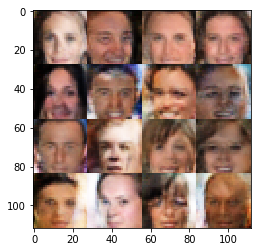

Epoch 1 out of 1
Iteration 5610
Discriminator loss: 1.177663
Generator loss: 0.753886
Epoch 1 out of 1
Iteration 5620
Discriminator loss: 1.206985
Generator loss: 0.724740
Epoch 1 out of 1
Iteration 5630
Discriminator loss: 1.252365
Generator loss: 0.652636
Epoch 1 out of 1
Iteration 5640
Discriminator loss: 0.870540
Generator loss: 1.193707
Epoch 1 out of 1
Iteration 5650
Discriminator loss: 1.229259
Generator loss: 0.675960
Epoch 1 out of 1
Iteration 5660
Discriminator loss: 1.214630
Generator loss: 0.957398
Epoch 1 out of 1
Iteration 5670
Discriminator loss: 1.229855
Generator loss: 0.739096
Epoch 1 out of 1
Iteration 5680
Discriminator loss: 1.202087
Generator loss: 1.003677
Epoch 1 out of 1
Iteration 5690
Discriminator loss: 0.868928
Generator loss: 1.357809
Epoch 1 out of 1
Iteration 5700
Discriminator loss: 1.324338
Generator loss: 0.676086


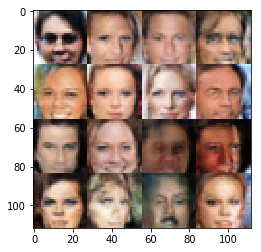

Epoch 1 out of 1
Iteration 5710
Discriminator loss: 1.172614
Generator loss: 0.776899
Epoch 1 out of 1
Iteration 5720
Discriminator loss: 1.084461
Generator loss: 0.926624
Epoch 1 out of 1
Iteration 5730
Discriminator loss: 0.994109
Generator loss: 1.023915
Epoch 1 out of 1
Iteration 5740
Discriminator loss: 1.605701
Generator loss: 0.576985
Epoch 1 out of 1
Iteration 5750
Discriminator loss: 1.181886
Generator loss: 0.701487
Epoch 1 out of 1
Iteration 5760
Discriminator loss: 1.342625
Generator loss: 0.563991
Epoch 1 out of 1
Iteration 5770
Discriminator loss: 1.345664
Generator loss: 0.547011
Epoch 1 out of 1
Iteration 5780
Discriminator loss: 1.545732
Generator loss: 0.511680
Epoch 1 out of 1
Iteration 5790
Discriminator loss: 1.478941
Generator loss: 0.499892
Epoch 1 out of 1
Iteration 5800
Discriminator loss: 1.600723
Generator loss: 0.397919


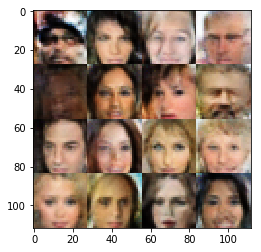

Epoch 1 out of 1
Iteration 5810
Discriminator loss: 1.393529
Generator loss: 0.547982
Epoch 1 out of 1
Iteration 5820
Discriminator loss: 1.324132
Generator loss: 0.668433
Epoch 1 out of 1
Iteration 5830
Discriminator loss: 0.992118
Generator loss: 0.956896
Epoch 1 out of 1
Iteration 5840
Discriminator loss: 1.619215
Generator loss: 0.384939
Epoch 1 out of 1
Iteration 5850
Discriminator loss: 1.111209
Generator loss: 0.957455
Epoch 1 out of 1
Iteration 5860
Discriminator loss: 1.280674
Generator loss: 0.750695
Epoch 1 out of 1
Iteration 5870
Discriminator loss: 1.353500
Generator loss: 0.666745
Epoch 1 out of 1
Iteration 5880
Discriminator loss: 0.948162
Generator loss: 1.089768
Epoch 1 out of 1
Iteration 5890
Discriminator loss: 0.970817
Generator loss: 1.129879
Epoch 1 out of 1
Iteration 5900
Discriminator loss: 1.200903
Generator loss: 0.703689


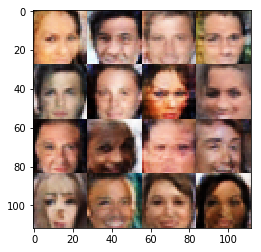

Epoch 1 out of 1
Iteration 5910
Discriminator loss: 1.483263
Generator loss: 0.490449
Epoch 1 out of 1
Iteration 5920
Discriminator loss: 1.606264
Generator loss: 0.400837
Epoch 1 out of 1
Iteration 5930
Discriminator loss: 1.509874
Generator loss: 0.445940
Epoch 1 out of 1
Iteration 5940
Discriminator loss: 1.202453
Generator loss: 0.683128
Epoch 1 out of 1
Iteration 5950
Discriminator loss: 1.009258
Generator loss: 1.340398
Epoch 1 out of 1
Iteration 5960
Discriminator loss: 1.340411
Generator loss: 0.645368
Epoch 1 out of 1
Iteration 5970
Discriminator loss: 1.495716
Generator loss: 0.463951
Epoch 1 out of 1
Iteration 5980
Discriminator loss: 1.486101
Generator loss: 0.481142
Epoch 1 out of 1
Iteration 5990
Discriminator loss: 1.129487
Generator loss: 0.834458
Epoch 1 out of 1
Iteration 6000
Discriminator loss: 1.188510
Generator loss: 0.895829


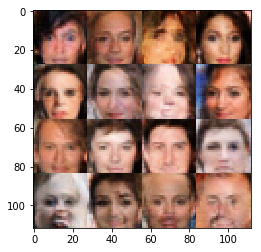

Epoch 1 out of 1
Iteration 6010
Discriminator loss: 1.183811
Generator loss: 0.756246
Epoch 1 out of 1
Iteration 6020
Discriminator loss: 1.249270
Generator loss: 0.647547
Epoch 1 out of 1
Iteration 6030
Discriminator loss: 1.511030
Generator loss: 0.498366
Epoch 1 out of 1
Iteration 6040
Discriminator loss: 1.312964
Generator loss: 0.648082
Epoch 1 out of 1
Iteration 6050
Discriminator loss: 1.837160
Generator loss: 0.312283
Epoch 1 out of 1
Iteration 6060
Discriminator loss: 1.237429
Generator loss: 0.689976
Epoch 1 out of 1
Iteration 6070
Discriminator loss: 1.410270
Generator loss: 0.651199
Epoch 1 out of 1
Iteration 6080
Discriminator loss: 1.211861
Generator loss: 0.760948
Epoch 1 out of 1
Iteration 6090
Discriminator loss: 1.331368
Generator loss: 0.616975
Epoch 1 out of 1
Iteration 6100
Discriminator loss: 1.147753
Generator loss: 0.874929


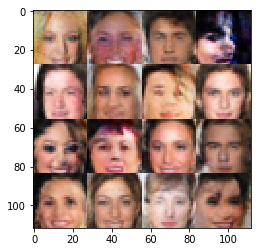

Epoch 1 out of 1
Iteration 6110
Discriminator loss: 1.527271
Generator loss: 0.438946
Epoch 1 out of 1
Iteration 6120
Discriminator loss: 1.076652
Generator loss: 0.816164
Epoch 1 out of 1
Iteration 6130
Discriminator loss: 1.475356
Generator loss: 0.526636
Epoch 1 out of 1
Iteration 6140
Discriminator loss: 1.401861
Generator loss: 0.651840
Epoch 1 out of 1
Iteration 6150
Discriminator loss: 1.607428
Generator loss: 0.386400
Epoch 1 out of 1
Iteration 6160
Discriminator loss: 1.148352
Generator loss: 0.851261
Epoch 1 out of 1
Iteration 6170
Discriminator loss: 1.461845
Generator loss: 0.631091
Epoch 1 out of 1
Iteration 6180
Discriminator loss: 1.660458
Generator loss: 0.369976
Epoch 1 out of 1
Iteration 6190
Discriminator loss: 1.097369
Generator loss: 0.884354
Epoch 1 out of 1
Iteration 6200
Discriminator loss: 1.059448
Generator loss: 1.034826


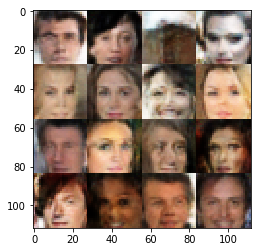

Epoch 1 out of 1
Iteration 6210
Discriminator loss: 0.817662
Generator loss: 1.619685
Epoch 1 out of 1
Iteration 6220
Discriminator loss: 1.292526
Generator loss: 0.656633
Epoch 1 out of 1
Iteration 6230
Discriminator loss: 1.074398
Generator loss: 0.883473
Epoch 1 out of 1
Iteration 6240
Discriminator loss: 1.501079
Generator loss: 0.470291
Epoch 1 out of 1
Iteration 6250
Discriminator loss: 1.546608
Generator loss: 0.437102
Epoch 1 out of 1
Iteration 6260
Discriminator loss: 1.032136
Generator loss: 1.067095
Epoch 1 out of 1
Iteration 6270
Discriminator loss: 1.180277
Generator loss: 0.688317
Epoch 1 out of 1
Iteration 6280
Discriminator loss: 1.316209
Generator loss: 0.657085
Epoch 1 out of 1
Iteration 6290
Discriminator loss: 1.215738
Generator loss: 0.899038
Epoch 1 out of 1
Iteration 6300
Discriminator loss: 1.138088
Generator loss: 0.911197


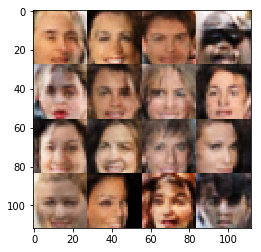

Epoch 1 out of 1
Iteration 6310
Discriminator loss: 1.280992
Generator loss: 0.636387
Epoch 1 out of 1
Iteration 6320
Discriminator loss: 1.477348
Generator loss: 0.535099
Epoch 1 out of 1
Iteration 6330
Discriminator loss: 1.608710
Generator loss: 0.481982


In [113]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.